# Treinamento utilizando a biblioteca Tensorflow + Keras

In [1]:
# bibliotecas proprias
from library.load_image_data import load_images
from library.preprocess_image import preprocess_image_tf, random_rotation, random_zoom, horizontal_flip, vertical_flip, adjust_brightness_contrast
from library.save_load_json import save_history, load_history

# importa as bibliotecas essenciais para trabalhar com tensorflow
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import json # para salvar o histórico
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, make_scorer, accuracy_score, roc_auc_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
def evaluate_model(y_true, y_pred, y_pred_proba):
    # Calculando a matriz de confusão
    confusion = confusion_matrix(y_true, y_pred)

    # Calculando a acurácia do modelo
    accuracy = accuracy_score(y_true, y_pred)

    # Calculando o F1 score
    f1 = f1_score(y_true, y_pred)

    # Calculando a AUC da curva ROC
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Exibindo os resultados
    print(f'Confusion Matrix:\n {confusion}')
    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC: {roc_auc}')

    # Plotando a curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
# plota a acurácia de treinamento e validação
def plot_accuracy(hist, epochs):
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']

    loss = hist['loss']
    val_loss = hist['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 4))

    # Subplot de acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    # Exibindo os últimos valores de acurácia no gráfico
    plt.text(epochs-1, acc[-1], f'{acc[-1]:.2f}', ha='right')
    plt.text(epochs-1, val_acc[-1], f'{val_acc[-1]:.2f}', ha='left')

    # Subplot de perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Exibindo os últimos valores de perda no gráfico
    plt.text(epochs-1, loss[-1], f'{loss[-1]:.2f}', ha='right')
    plt.text(epochs-1, val_loss[-1], f'{val_loss[-1]:.2f}', ha='left')

    plt.show()

In [5]:
dataset_path = 'dataset/'
df = load_images(dataset_path)

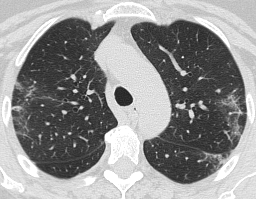

In [6]:
df['Image'][0]

In [7]:
df.describe()


Image  Label
count                                                2481   2481
unique                                               2479      2
top     <PIL.PngImagePlugin.PngImageFile image mode=RG...  COVID
freq                                                    2   1252

In [8]:
# Convertendo rótulos de strings para inteiros
label_to_int = {'COVID': 1, 'non-COVID': 0}
df['Label'] = df['Label'].replace(label_to_int)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['Image'], df['Label'], test_size=0.2, random_state=42)

In [10]:
batch_size = 32
img_size = 128

In [10]:
# função que transforma as imagens e rótulos em tensores
def create_dataset(images, labels):
    def generator():
        for img, label in zip(images, labels):  
            img = preprocess_image_tf(img)
            img = img.astype(np.float32)            
            label = np.int32(label)          
            yield img, label
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
        tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )

In [11]:
# função que transforma as imagens e rótulos em tensores
def create_dataset_image_size(images, labels, image_size):
    def generator():
        for img, label in zip(images, labels):  
            img = preprocess_image_tf(img, (image_size, image_size))
            img = img.astype(np.float32)            
            label = np.int32(label)          
            yield img, label
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
        tf.TensorSpec(shape=(image_size, image_size, 3), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )

In [12]:
# criando os datasets
train_ds = create_dataset(X_train, y_train).batch(batch_size)
val_ds = create_dataset(X_test, y_test).batch(batch_size)

In [12]:
def create_model():
    model = tf.keras.Sequential([
        # camada de entrada
        tf.keras.layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
        # camadas ocultas
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        # camada de saída
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model

In [13]:
def create_model_image_size(image_size):
    model = tf.keras.Sequential([
        # camada de entrada
        tf.keras.layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
        # camadas ocultas
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        # camada de saída
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model

In [14]:
# modelo com regularização l2
def create_model_l2(image_size):
    model = tf.keras.Sequential([
        # camada de entrada
        tf.keras.layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
        # camadas ocultas
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        # camada de saída
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model


In [14]:
def create_model_drop():
    model = tf.keras.Sequential([
        # camada de entrada
        tf.keras.layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
        # camadas ocultas
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        # camada de saída
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model

In [14]:
final_model = create_model()
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [15]:
epochs = 10
history = final_model.fit(train_ds, epochs=epochs, batch_size=32, validation_data=val_ds)

Epoch 1/10
62/62 [==============================] - 31s 472ms/step - loss: 0.6504 - accuracy: 0.6305 - val_loss: 0.5454 - val_accuracy: 0.7364
Epoch 2/10
62/62 [==============================] - 27s 430ms/step - loss: 0.4435 - accuracy: 0.7944 - val_loss: 0.4218 - val_accuracy: 0.8048
Epoch 3/10
62/62 [==============================] - 30s 491ms/step - loss: 0.3392 - accuracy: 0.8503 - val_loss: 0.3373 - val_accuracy: 0.8652
Epoch 4/10
62/62 [==============================] - 28s 447ms/step - loss: 0.2794 - accuracy: 0.8826 - val_loss: 0.2929 - val_accuracy: 0.8873
Epoch 5/10
62/62 [==============================] - 26s 424ms/step - loss: 0.2569 - accuracy: 0.8901 - val_loss: 0.3058 - val_accuracy: 0.8934
Epoch 6/10
62/62 [==============================] - 26s 423ms/step - loss: 0.1840 - accuracy: 0.9315 - val_loss: 0.3362 - val_accuracy: 0.8672
Epoch 7/10
62/62 [==============================] - 26s 421ms/step - loss: 0.1362 - accuracy: 0.9471 - val_loss: 0.2760 - val_accuracy: 0.8954

In [16]:
filename = '01_treino_base'
final_model.save(f'saved_models/{filename}.h5')
save_history(history, filename)

16/16 [==============================] - 2s 137ms/step
Confusion Matrix:
 [[231  27]
 [ 12 227]]
Accuracy: 0.9215291750503019
F1 Score: 0.920892494929006
ROC AUC: 0.9765982290551718


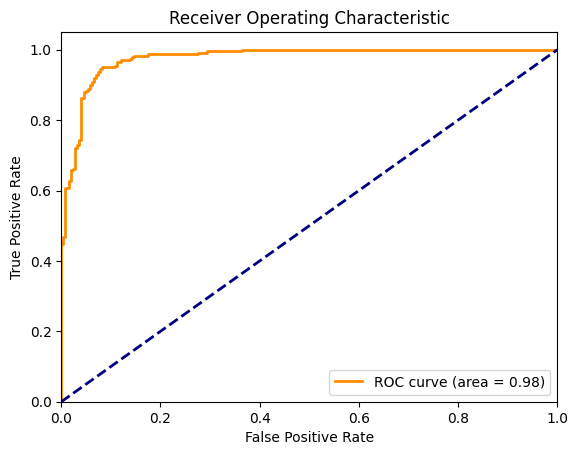

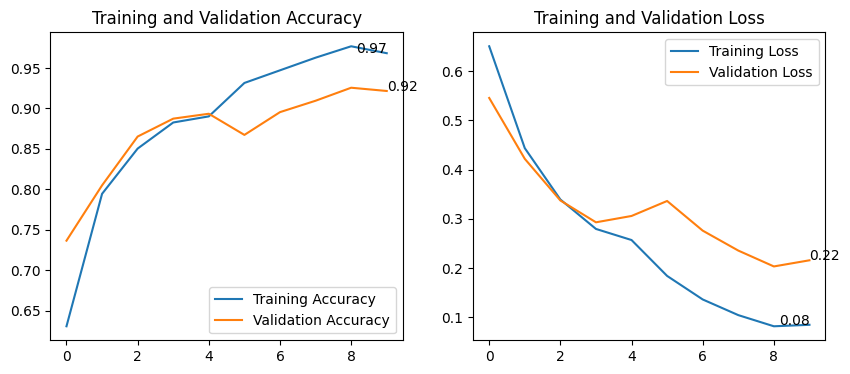

In [18]:
filename = '01_treino_base'
model_01_treino_base = load_model(f'saved_models/{filename}.h5')
history_dict = load_history(filename)
# Faça previsões no conjunto de teste
# tentar passar esse carinha para history.predict
y_pred_proba = model_01_treino_base.predict(val_ds)
y_pred = (y_pred_proba > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true, y_pred, y_pred_proba)
# Verificando se o histórico foi carregado corretamente
if history_dict is not None:
    # Usando o histórico carregado para plotar gráficos
    plot_accuracy(history_dict, epochs)
else:
    print("Error: Failed to load history.")

* As observações iniciais apontam que o modelo, ao decorrer das épocas, perde acurácia na partição de validação, o que pode indicar o início de overfitting. O val_loss e val_accuracy estabilizaram por volta da 6ª epoca
* Abaixo, aumenta-se a quantidade de épocas para 20 a fim de confirmar essa tendência.
* Apesar disso, o F1 score chegou a 0.92.

In [19]:
epochs_over_test = 20
final_model_over_test = create_model()
history_over_test = final_model_over_test.fit(train_ds, epochs=epochs_over_test, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 31s 477ms/step - loss: 0.6439 - accuracy: 0.6603 - val_loss: 0.5074 - val_accuracy: 0.7666
Epoch 2/20
62/62 [==============================] - 29s 463ms/step - loss: 0.4632 - accuracy: 0.7848 - val_loss: 0.4577 - val_accuracy: 0.7787
Epoch 3/20
62/62 [==============================] - 27s 442ms/step - loss: 0.3480 - accuracy: 0.8458 - val_loss: 0.3628 - val_accuracy: 0.8410
Epoch 4/20
62/62 [==============================] - 30s 491ms/step - loss: 0.2848 - accuracy: 0.8795 - val_loss: 0.3179 - val_accuracy: 0.8672
Epoch 5/20
62/62 [==============================] - 30s 487ms/step - loss: 0.2236 - accuracy: 0.9148 - val_loss: 0.2872 - val_accuracy: 0.8833
Epoch 6/20
62/62 [==============================] - 29s 470ms/step - loss: 0.1689 - accuracy: 0.9355 - val_loss: 0.2726 - val_accuracy: 0.8813
Epoch 7/20
62/62 [==============================] - 29s 469ms/step - loss: 0.1491 - accuracy: 0.9390 - val_loss: 0.3294 - val_accuracy: 0.8531

In [20]:
filename = '02_treino_over_test'
final_model_over_test.save(f'saved_models/{filename}.h5')
save_history(history_over_test, filename)

16/16 [==============================] - 2s 133ms/step
Confusion Matrix:
 [[227  31]
 [  4 235]]
Accuracy: 0.9295774647887324
F1 Score: 0.9306930693069306
ROC AUC: 0.9806039375952774


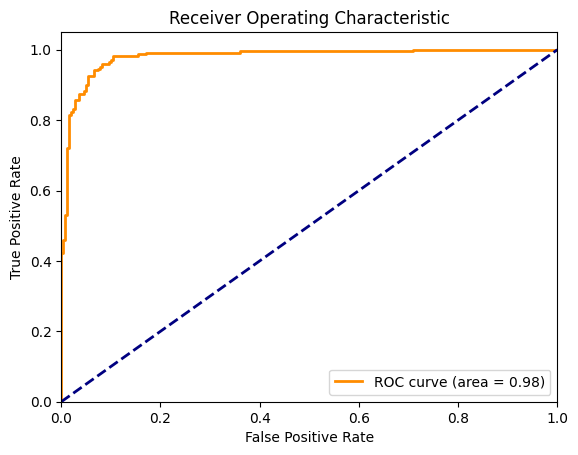

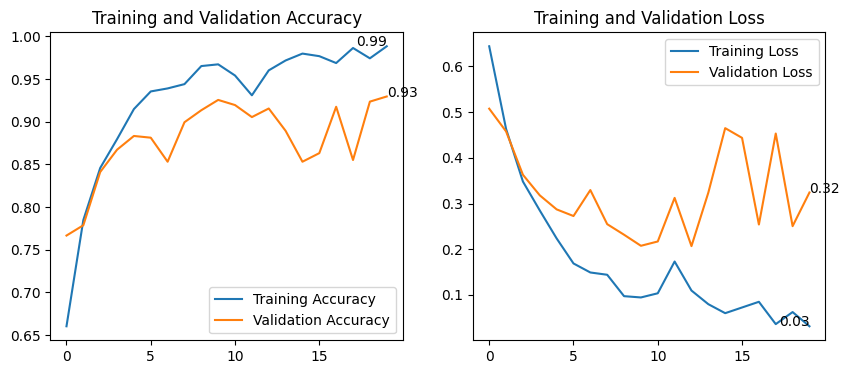

In [21]:
filename = '02_treino_over_test'
model_02_treino_over_test = load_model(f'saved_models/{filename}.h5')
history_dict_over = load_history(filename)
y_pred_proba_over_test = model_02_treino_over_test.predict(val_ds)
y_pred_over_test = (y_pred_proba_over_test > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_over_test = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_over_test, y_pred_over_test, y_pred_proba_over_test)
plot_accuracy(history_dict_over, epochs_over_test)


* Observa-se claramente que o treinamento perdeu muita qualidade depois da 6ª época, levando a um overfitting. Mesmo com o overfiting o F1 score chegou a 0.93, um resultado interessante para este segundo teste.
* Como um terceiro teste, aplicou-se então o dropout de alguns neurônios, mantendo-se as 20 épocas para verificar se o modelo consegue generalizar os dados.

In [22]:
epochs_drop = 20
final_model_drop = create_model_drop()
history_drop = final_model_drop.fit(train_ds, epochs=epochs_drop, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 32s 492ms/step - loss: 0.7234 - accuracy: 0.5474 - val_loss: 0.6399 - val_accuracy: 0.6861
Epoch 2/20
62/62 [==============================] - 29s 475ms/step - loss: 0.5636 - accuracy: 0.7359 - val_loss: 0.5708 - val_accuracy: 0.7082
Epoch 3/20
62/62 [==============================] - 31s 498ms/step - loss: 0.4276 - accuracy: 0.8044 - val_loss: 0.4695 - val_accuracy: 0.7948
Epoch 4/20
62/62 [==============================] - 30s 488ms/step - loss: 0.3373 - accuracy: 0.8569 - val_loss: 0.3572 - val_accuracy: 0.8692
Epoch 5/20
62/62 [==============================] - 30s 485ms/step - loss: 0.3013 - accuracy: 0.8710 - val_loss: 0.3107 - val_accuracy: 0.8853
Epoch 6/20
62/62 [==============================] - 30s 489ms/step - loss: 0.2431 - accuracy: 0.9012 - val_loss: 0.3109 - val_accuracy: 0.8994
Epoch 7/20
62/62 [==============================] - 34s 554ms/step - loss: 0.2078 - accuracy: 0.9168 - val_loss: 0.3212 - val_accuracy: 0.8813

In [23]:
filename = '03_treino_drop'
final_model_drop.save(f'saved_models/{filename}.h5')
save_history(history_drop, filename)

16/16 [==============================] - 2s 117ms/step
Confusion Matrix:
 [[245  13]
 [ 49 190]]
Accuracy: 0.8752515090543259
F1 Score: 0.8597285067873303
ROC AUC: 0.9692355097142487


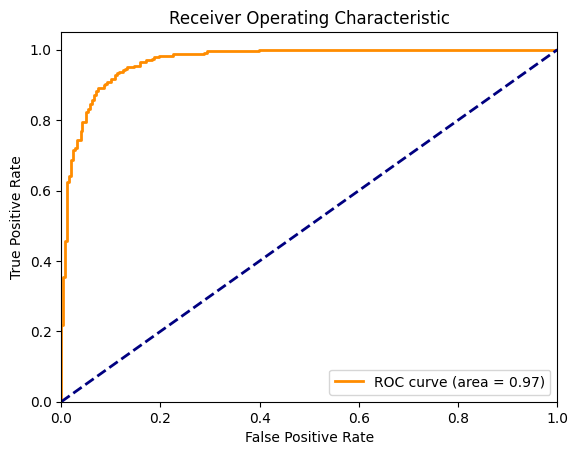

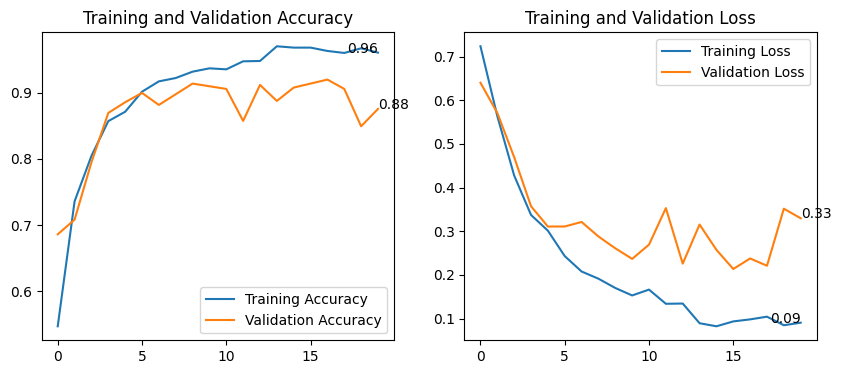

In [24]:
filename = '03_treino_drop'
model_03_treino_drop = load_model(f'saved_models/{filename}.h5')
history_dict_drop = load_history(filename)
y_pred_proba_drop = model_03_treino_drop.predict(val_ds)
y_pred_drop = (y_pred_proba_drop > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_drop = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_drop, y_pred_drop, y_pred_proba_drop)
plot_accuracy(history_dict_drop, epochs_drop)

* Observa-se que neste treinamento houve um pouco mais de consistência entre treinamento e validação, mas apresentou também a tendência a fazer o overfitting. Após a 9ª época o sistema estabilizou e a partição de validação não melhorou muito.

### Abaixo, considerou-se a aplicação de image augmentation com as seguintes modificações:
* Alteração na rotação
* Alteração no filtro de canais RGB
* Alteração no brilho/constraste
* Alteração no espelhamento das imagens (flip vertical/horizontal)

* Como se tratam de dados médicos, entende-se que a alteração de algumas características pode causar diagnósticos equivocados, por isso serão testadas as técnicas uma a uma, e depois, uma combinação das técnicas que surtiram melhores efeitos.

In [16]:
# aplica zoom randomico na imagem
data_aug_zoom = keras.Sequential(
    [        
        layers.RandomZoom(0.1)
    ],
    name="data_aug_zoom"
)

In [19]:
# aplica espelhamento randômico na imagem
data_aug_flip = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical",
                          input_shape=(img_size, img_size, 3))
    ],
    name="data_aug_flip"
)

In [20]:
# aplica rotação randômica na imagem
data_aug_rot = keras.Sequential(
    [        
        layers.RandomRotation(0.1)
    ],
    name="data_aug_rot"
)

In [21]:
def random_hue(image):
    return tf.image.random_hue(image, max_delta=0.08)

In [22]:
# aplica ajustes no brilho, contraste e camadas de cores na imagem
data_aug_colors = keras.Sequential(
    [
        layers.RandomContrast(factor=(0.2, 0.5)),
        layers.RandomBrightness(factor=0.3),
        layers.Lambda(random_hue)
    ],
    name="data_aug_cores"
)

In [23]:
# aplica ajustes no brilho, contraste e camadas de cores na imagem
data_aug_bc = keras.Sequential(
    [
        layers.RandomContrast(factor=(0.2, 0.5)),
        layers.RandomBrightness(factor=0.3),        
    ],
    name="data_aug_bc"
)

In [24]:
# aplica ajustes no brilho, contraste e camadas de cores na imagem
data_aug_hue = keras.Sequential(
    [        
        layers.Lambda(random_hue)
    ],
    name="data_aug_hue"
)

In [25]:
data_aug_comb = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical",
                          input_shape=(img_size, img_size, 3)),
        layers.RandomRotation(0.1),
        layers.RandomContrast(factor=(0.2, 0.5)),
        layers.RandomBrightness(factor=0.3),
        layers.Lambda(random_hue),
        layers.RandomZoom(0.1)
    ],
    name="data_aug_comb"
)

In [26]:
data_aug_zoom_flip_hue = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical",
                          input_shape=(img_size, img_size, 3)),                
        layers.Lambda(random_hue),
        layers.RandomZoom(0.1)
    ],
    name="data_aug_zoom_flip_hue"
)

In [27]:
data_aug_zoom_flip = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical",
                          input_shape=(img_size, img_size, 3)),                        
        layers.RandomZoom(0.1)
    ],
    name="data_aug_zoom_flip"
)

In [28]:
data_aug_zoom_hue = keras.Sequential(
    [        
        layers.Lambda(random_hue),
        layers.RandomZoom(0.1)
    ],
    name="data_aug_zoom_hue"
)

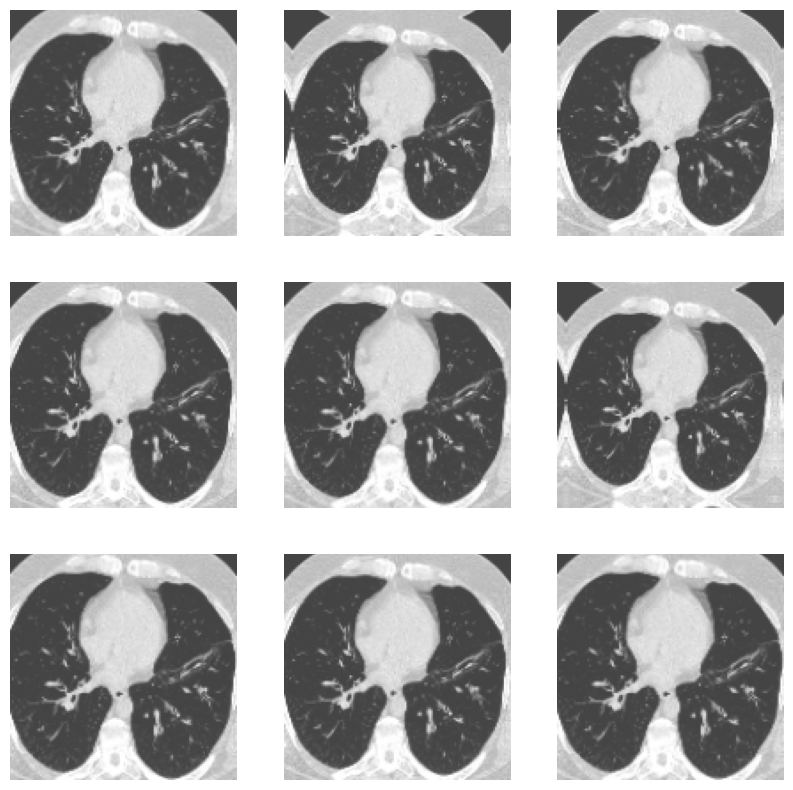

In [33]:
# Teste do zoom
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images_zoom = data_aug_zoom(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images_zoom[0].numpy().astype("uint8"))
    plt.axis("off")

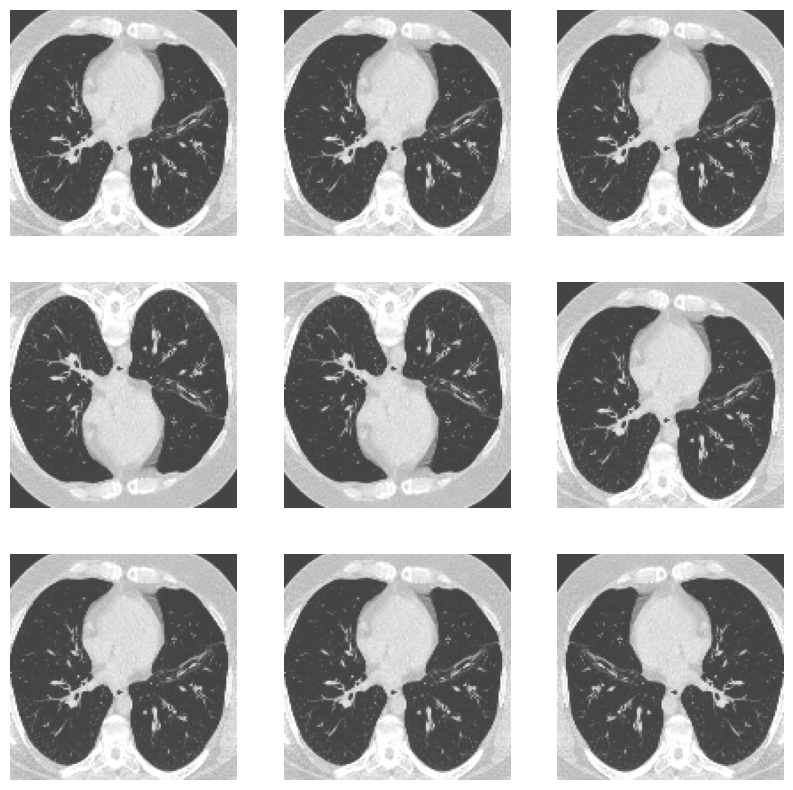

In [34]:
# Teste do flip
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images_flip = data_aug_flip(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images_flip[0].numpy().astype("uint8"))
    plt.axis("off")

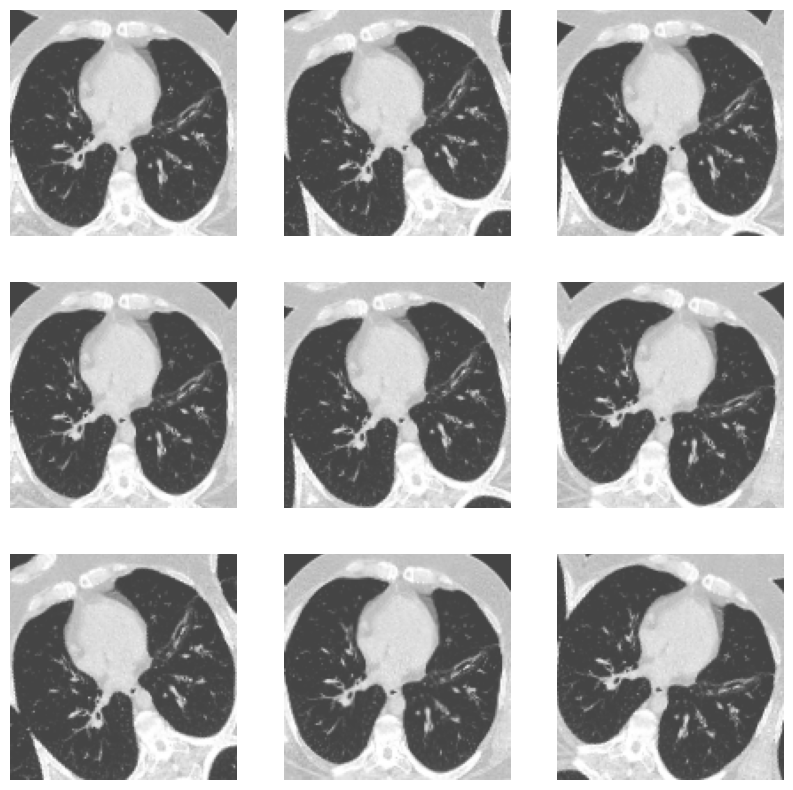

In [35]:
# Teste da rotação
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images_rot = data_aug_rot(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images_rot[0].numpy().astype("uint8"))
    plt.axis("off")

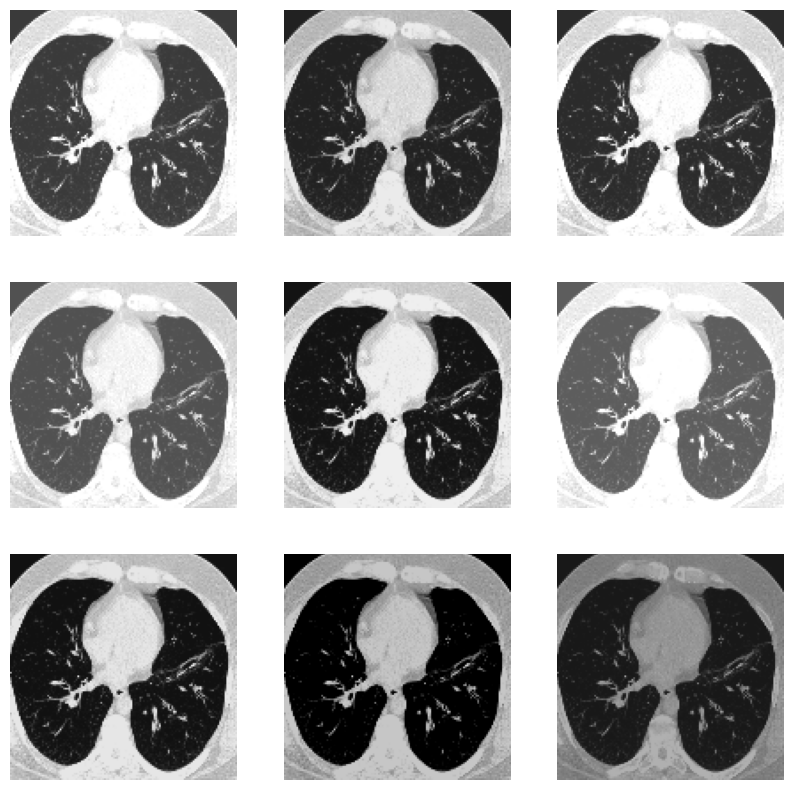

In [36]:
# Teste de cores
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images_colors = data_aug_colors(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images_colors[0].numpy().astype("uint8"))
    plt.axis("off")

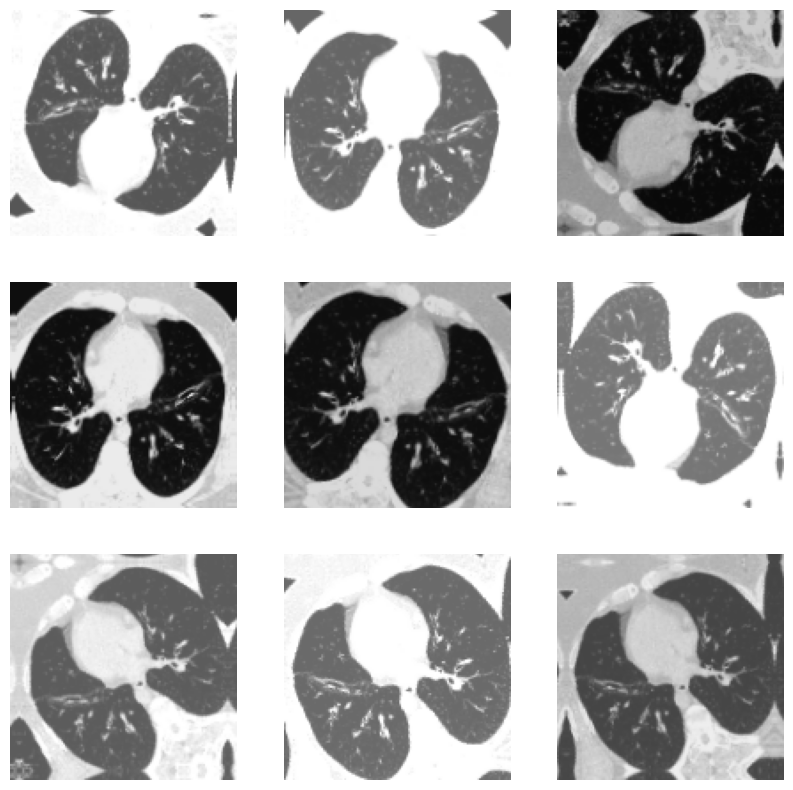

In [37]:
# Teste combinando as técnicas
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images_comb = data_aug_comb(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images_comb[0].numpy().astype("uint8"))
    plt.axis("off")

* As técnicas de image augmentation foram testadas e estão funcionando. Agora testamos as técnicas isoladamente para verificar o desempenho do modelo.

### Aplicando o treinamento com zoom sem drop de neuronios

In [39]:
epochs_zoom = 20
final_model_zoom = create_model()
augmented_train_ds_zoom = train_ds.map(lambda x, y: (data_aug_zoom(x, training=True), y))
history_zoom = final_model_zoom.fit(augmented_train_ds_zoom, epochs=epochs_zoom, batch_size=32, validation_data=val_ds)

Epoch 1/20


62/62 [==============================] - 30s 450ms/step - loss: 0.7215 - accuracy: 0.5459 - val_loss: 0.6664 - val_accuracy: 0.5312
Epoch 2/20
62/62 [==============================] - 26s 412ms/step - loss: 0.5833 - accuracy: 0.6951 - val_loss: 0.5695 - val_accuracy: 0.6962
Epoch 3/20
62/62 [==============================] - 26s 420ms/step - loss: 0.4656 - accuracy: 0.7868 - val_loss: 0.5653 - val_accuracy: 0.7163
Epoch 4/20
62/62 [==============================] - 26s 417ms/step - loss: 0.3920 - accuracy: 0.8327 - val_loss: 0.4907 - val_accuracy: 0.7706
Epoch 5/20
62/62 [==============================] - 26s 419ms/step - loss: 0.3299 - accuracy: 0.8569 - val_loss: 0.3445 - val_accuracy: 0.8592
Epoch 6/20
62/62 [==============================] - 26s 416ms/step - loss: 0.2836 - accuracy: 0.8816 - val_loss: 0.4463 - val_accuracy: 0.8089
Epoch 7/20
62/62 [==============================] - 26s 425ms/step - loss: 0.2556 - accuracy: 0.8967 - val_loss: 0.3018 - val_accuracy: 0.8793
Epoch 8/20

In [40]:
filename = '04_treino_zoom'
final_model_zoom.save(f'saved_models/{filename}.h5')
save_history(history_zoom, filename)

16/16 [==============================] - 2s 120ms/step
Confusion Matrix:
 [[246  12]
 [ 10 229]]
Accuracy: 0.9557344064386318
F1 Score: 0.9541666666666666
ROC AUC: 0.9923129317894327


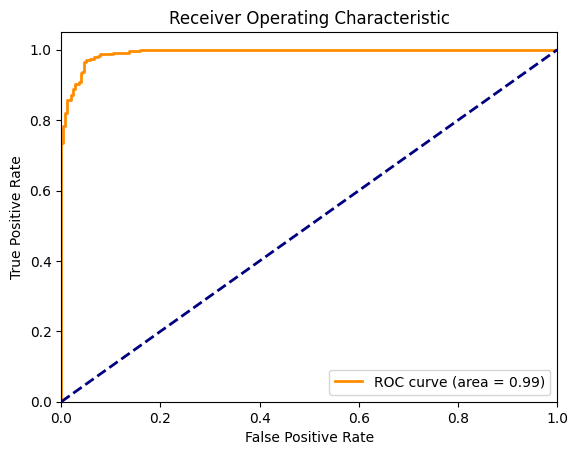

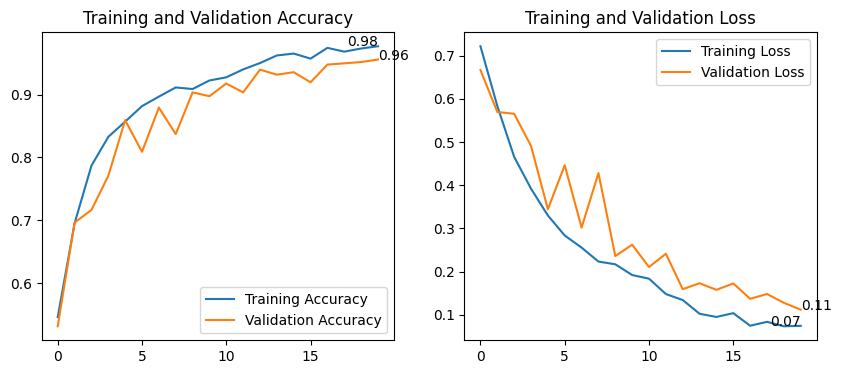

In [41]:
filename = '04_treino_zoom'
model_04_treino_zoom = load_model(f'saved_models/{filename}.h5')
history_dict_zoom = load_history(filename)
y_pred_proba_zoom = model_04_treino_zoom.predict(val_ds)
y_pred_zoom = (y_pred_proba_zoom > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_zoom = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_zoom, y_pred_zoom, y_pred_proba_zoom)
plot_accuracy(history_dict_zoom, epochs_zoom)

* Aplicando o treinamento com o data augmentation com a transformação zoom, observa-se uma melhora considerável no modelo e maior consistência no treinamento. A queda na perda da validação foi contínua até o final das 20 épocas.
* A seguir repetimos o treinamento, agora realizando o drop de alguns neurônios

In [42]:
epochs_zoom2 = 20
final_model_zoom2 = create_model_drop()
augmented_train_ds_zoom2 = train_ds.map(lambda x, y: (data_aug_zoom(x, training=True), y))
history_zoom2 = final_model_zoom2.fit(augmented_train_ds_zoom2, epochs=epochs_zoom2, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 29s 439ms/step - loss: 0.6745 - accuracy: 0.6346 - val_loss: 0.5502 - val_accuracy: 0.7425
Epoch 2/20
62/62 [==============================] - 28s 444ms/step - loss: 0.4806 - accuracy: 0.7757 - val_loss: 0.5516 - val_accuracy: 0.7203
Epoch 3/20
62/62 [==============================] - 28s 456ms/step - loss: 0.4145 - accuracy: 0.8196 - val_loss: 0.5562 - val_accuracy: 0.7103
Epoch 4/20
62/62 [==============================] - 28s 456ms/step - loss: 0.3599 - accuracy: 0.8417 - val_loss: 0.4842 - val_accuracy: 0.7706
Epoch 5/20
62/62 [==============================] - 26s 417ms/step - loss: 0.3423 - accuracy: 0.8528 - val_loss: 0.3308 - val_accuracy: 0.8793
Epoch 6/20
62/62 [==============================] - 26s 416ms/step - loss: 0.3110 - accuracy: 0.8705 - val_loss: 0.3197 - val_accuracy: 0.8793
Epoch 7/20
62/62 [==============================] - 26s 419ms/step - loss: 0.2933 - accuracy: 0.8810 - val_loss: 0.3013 - val_accuracy: 0.8813

In [43]:
filename = '05_treino_zoom2'
final_model_zoom2.save(f'saved_models/{filename}.h5')
save_history(history_zoom2, filename)

16/16 [==============================] - 2s 114ms/step
Confusion Matrix:
 [[250   8]
 [ 17 222]]
Accuracy: 0.9496981891348089
F1 Score: 0.9466950959488272
ROC AUC: 0.9917291038240732


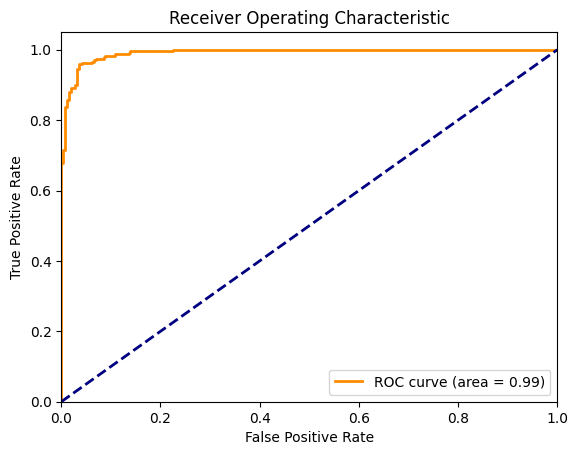

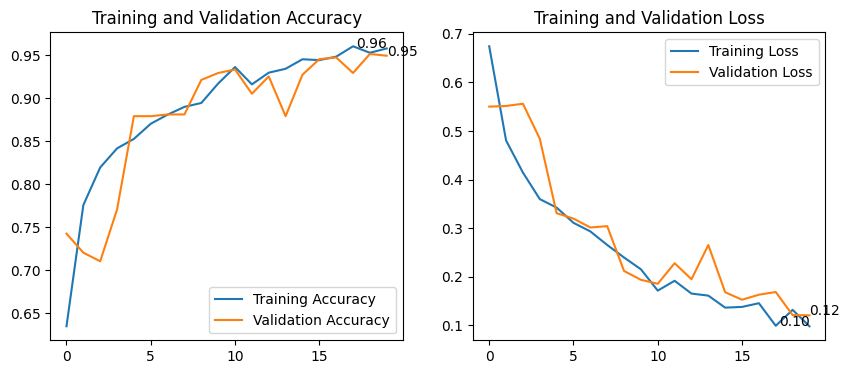

In [44]:
filename = '05_treino_zoom2'
model_05_treino_zoom2 = load_model(f'saved_models/{filename}.h5')
history_dict_zoom2 = load_history(filename)
y_pred_proba_zoom2 = model_05_treino_zoom2.predict(val_ds)
y_pred_zoom2 = (y_pred_proba_zoom2 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_zoom2 = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_zoom2, y_pred_zoom2, y_pred_proba_zoom2)
plot_accuracy(history_dict_zoom2, epochs_zoom2)

* Mais uma vez, adicionando o drop aleatórios de alguns neurônios, o modelo apresentou melhora significativa, com o F1 score chegando a 0.95, sendo um resultado bastante promissor.
* A seguir aplica=se a técnica de aumento de dados com espelhamento horizontal e vertical isoladamente

### Treinamento com espelhamento horizontal e vertical sem drop

In [45]:
epochs_flip = 20
final_model_flip = create_model()
augmented_train_ds_flip = train_ds.map(lambda x, y: (data_aug_flip(x, training=True), y))
history_flip = final_model_flip.fit(augmented_train_ds_flip, epochs=epochs_flip, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 27s 408ms/step - loss: 0.6676 - accuracy: 0.6184 - val_loss: 0.6300 - val_accuracy: 0.5895
Epoch 2/20
62/62 [==============================] - 25s 405ms/step - loss: 0.5345 - accuracy: 0.7404 - val_loss: 0.4678 - val_accuracy: 0.8109
Epoch 3/20
62/62 [==============================] - 25s 409ms/step - loss: 0.4687 - accuracy: 0.7742 - val_loss: 0.3891 - val_accuracy: 0.8169
Epoch 4/20
62/62 [==============================] - 25s 410ms/step - loss: 0.4208 - accuracy: 0.7984 - val_loss: 0.4162 - val_accuracy: 0.8048
Epoch 5/20
62/62 [==============================] - 25s 410ms/step - loss: 0.3487 - accuracy: 0.8392 - val_loss: 0.3500 - val_accuracy: 0.8330
Epoch 6/20
62/62 [==============================] - 26s 414ms/step - loss: 0.3320 - accuracy: 0.8493 - val_loss: 0.3193 - val_accuracy: 0.8410
Epoch 7/20
62/62 [==============================] - 28s 445ms/step - loss: 0.2995 - accuracy: 0.8700 - val_loss: 0.3289 - val_accuracy: 0.8551

In [46]:
filename = '06_treino_flip'
final_model_flip.save(f'saved_models/{filename}.h5')
save_history(history_flip, filename)

16/16 [==============================] - 2s 110ms/step
Confusion Matrix:
 [[246  12]
 [ 56 183]]
Accuracy: 0.8631790744466801
F1 Score: 0.8433179723502305
ROC AUC: 0.9625863578865428


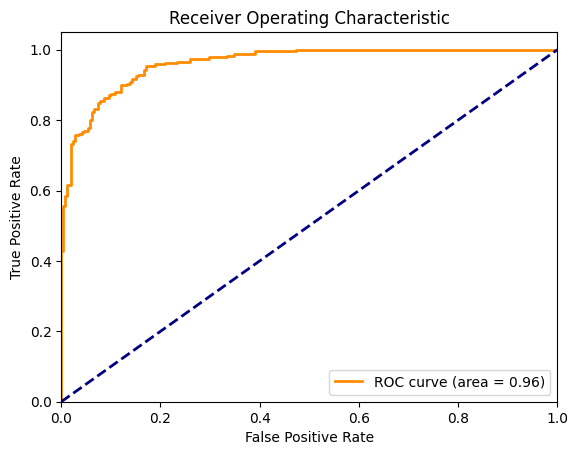

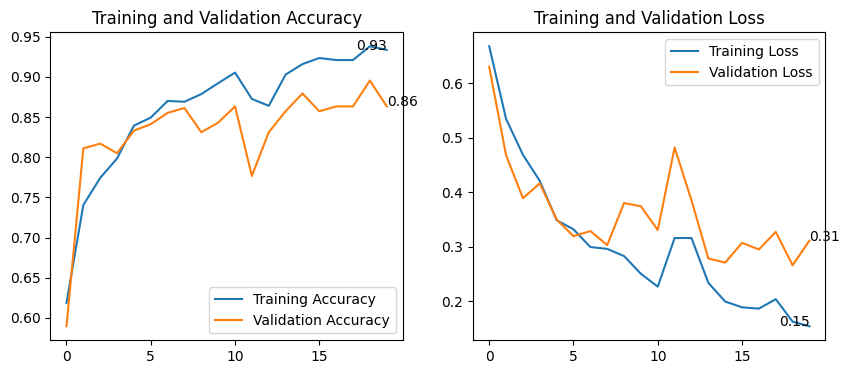

In [47]:
filename = '06_treino_flip'
model_06_treino_flip = load_model(f'saved_models/{filename}.h5')
history_dict_flip = load_history(filename)
y_pred_proba_flip = model_06_treino_flip.predict(val_ds)
y_pred_flip = (y_pred_proba_flip > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_flip = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_flip, y_pred_flip, y_pred_proba_flip)
plot_accuracy(history_dict_flip, epochs_flip)

* A técncia de transformação de espelhamento não surtiu o mesmo efeito que a técnica de zoom, perdendo um pouco da qualidade do treinamento. Seu F1 score ficou próximo a 0.89. 
* Abaixo aplica-se a mesma técnica com o drop de alguns neurônios.

In [48]:
epochs_flip2 = 20
final_model_flip2 = create_model_drop()
augmented_train_ds_flip2 = train_ds.map(lambda x, y: (data_aug_flip(x, training=True), y))
history_flip2 = final_model_flip2.fit(augmented_train_ds_flip2, epochs=epochs_flip2, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 28s 417ms/step - loss: 0.7068 - accuracy: 0.5252 - val_loss: 0.6914 - val_accuracy: 0.5191
Epoch 2/20
62/62 [==============================] - 26s 415ms/step - loss: 0.6224 - accuracy: 0.6542 - val_loss: 0.6046 - val_accuracy: 0.6982
Epoch 3/20
62/62 [==============================] - 26s 419ms/step - loss: 0.5238 - accuracy: 0.7399 - val_loss: 0.4473 - val_accuracy: 0.7928
Epoch 4/20
62/62 [==============================] - 26s 418ms/step - loss: 0.4575 - accuracy: 0.7797 - val_loss: 0.4443 - val_accuracy: 0.8189
Epoch 5/20
62/62 [==============================] - 26s 411ms/step - loss: 0.4175 - accuracy: 0.8085 - val_loss: 0.4143 - val_accuracy: 0.8249
Epoch 6/20
62/62 [==============================] - 26s 417ms/step - loss: 0.3931 - accuracy: 0.8251 - val_loss: 0.3237 - val_accuracy: 0.8652
Epoch 7/20
62/62 [==============================] - 26s 420ms/step - loss: 0.3514 - accuracy: 0.8448 - val_loss: 0.3883 - val_accuracy: 0.8209

In [49]:
filename = '07_treino_flip2'
final_model_flip2.save(f'saved_models/{filename}.h5')
save_history(history_flip2, filename)

16/16 [==============================] - 2s 107ms/step
Confusion Matrix:
 [[232  26]
 [ 23 216]]
Accuracy: 0.9014084507042254
F1 Score: 0.8981288981288981
ROC AUC: 0.9708572540624696


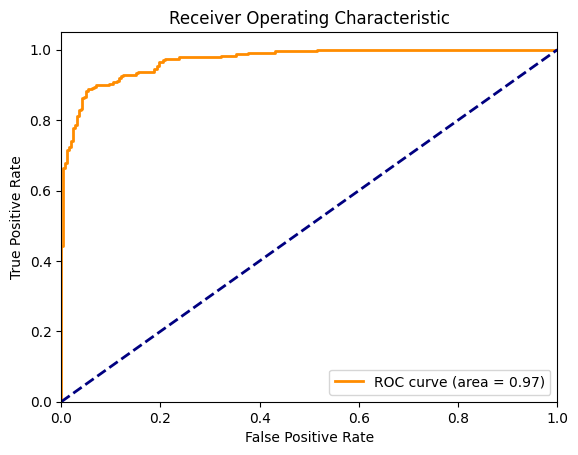

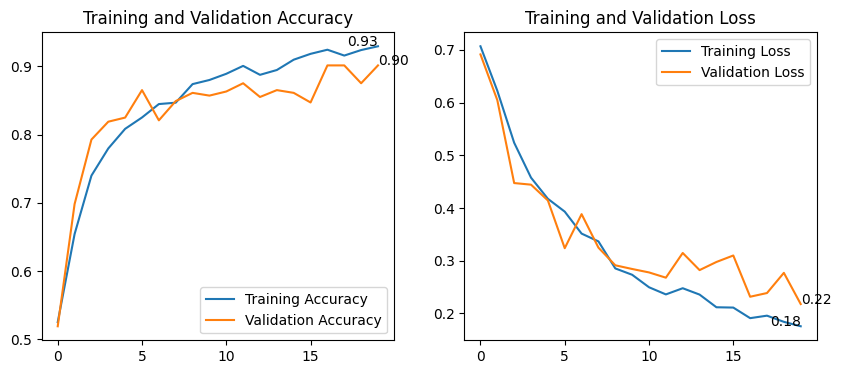

In [50]:
filename = '07_treino_flip2'
model_07_treino_flip2 = load_model(f'saved_models/{filename}.h5')
history_dict_flip2 = load_history(filename)
y_pred_proba_flip2 = model_07_treino_flip2.predict(val_ds)
y_pred_flip2 = (y_pred_proba_flip2 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_flip2 = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_flip2, y_pred_flip2, y_pred_proba_flip2)
plot_accuracy(history_dict_flip2, epochs_flip2)

* Com o drop de alguns neurônios o resultado fo F1 score caiu para 0.87, ou seja, não é uma boa técnica de aumento de dados para este conjunto de dados.
* Aplica-se então a técnica de ajuste de brilho, cor e contraste.

### Treinamento com aumento de dados e transformações em brilho, cor e contraste

In [51]:
epochs_color = 20
final_model_color = create_model()
augmented_train_ds_color = train_ds.map(lambda x, y: (data_aug_colors(x, training=True), y))
history_color = final_model_color.fit(augmented_train_ds_color, epochs=epochs_color, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 26s 396ms/step - loss: 0.6718 - accuracy: 0.5922 - val_loss: 0.6216 - val_accuracy: 0.6600
Epoch 2/20
62/62 [==============================] - 24s 394ms/step - loss: 0.5035 - accuracy: 0.7631 - val_loss: 0.4261 - val_accuracy: 0.8149
Epoch 3/20
62/62 [==============================] - 24s 394ms/step - loss: 0.3959 - accuracy: 0.8185 - val_loss: 0.4736 - val_accuracy: 0.7907
Epoch 4/20
62/62 [==============================] - 24s 390ms/step - loss: 0.3463 - accuracy: 0.8498 - val_loss: 0.4028 - val_accuracy: 0.8129
Epoch 5/20
62/62 [==============================] - 24s 389ms/step - loss: 0.3198 - accuracy: 0.8669 - val_loss: 0.3687 - val_accuracy: 0.8310
Epoch 6/20
62/62 [==============================] - 24s 393ms/step - loss: 0.2859 - accuracy: 0.8821 - val_loss: 0.3070 - val_accuracy: 0.8712
Epoch 7/20
62/62 [==============================] - 24s 395ms/step - loss: 0.2440 - accuracy: 0.9027 - val_loss: 0.3160 - val_accuracy: 0.8612

In [52]:
filename = '08_treino_color'
final_model_color.save(f'saved_models/{filename}.h5')
save_history(history_color, filename)

16/16 [==============================] - 2s 106ms/step
Confusion Matrix:
 [[251   7]
 [ 65 174]]
Accuracy: 0.8551307847082495
F1 Score: 0.8285714285714286
ROC AUC: 0.968716551522818


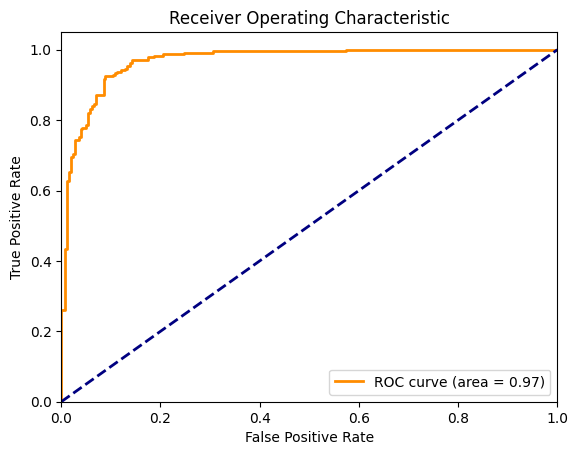

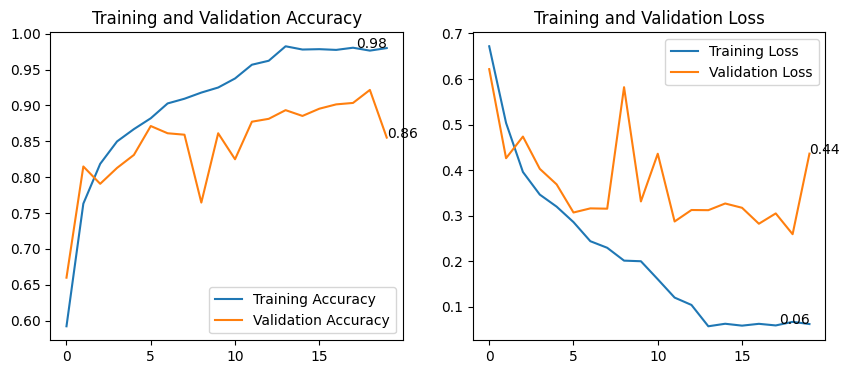

In [53]:
filename = '08_treino_color'
model_08_treino_color = load_model(f'saved_models/{filename}.h5')
history_dict_color = load_history(filename)
y_pred_proba_color = model_08_treino_color.predict(val_ds)
y_pred_color = (y_pred_proba_color > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_color = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_color, y_pred_color, y_pred_proba_color)
plot_accuracy(history_dict_color, epochs_color)

* O treinamento com ajuste das cores das imagens, apesar de ter apresentado um f1 score de 0.91, apresentou um desempenho muito pobre com relação a acurácia e perda da validação, o que demonstra a tendência ao overfitting. 
* Tenta-se reverter essa tendencia com o drop de alguns neurônios no próximo treinamento.

In [54]:
epochs_color2 = 20
final_model_color2 = create_model_drop()
augmented_train_ds_color2 = train_ds.map(lambda x, y: (data_aug_colors(x, training=True), y))
history_color2 = final_model_color2.fit(augmented_train_ds_color2, epochs=epochs_color2, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 28s 415ms/step - loss: 0.6891 - accuracy: 0.5716 - val_loss: 0.6639 - val_accuracy: 0.5936
Epoch 2/20
62/62 [==============================] - 25s 404ms/step - loss: 0.5521 - accuracy: 0.7293 - val_loss: 0.4773 - val_accuracy: 0.7847
Epoch 3/20
62/62 [==============================] - 25s 411ms/step - loss: 0.4370 - accuracy: 0.8004 - val_loss: 0.4665 - val_accuracy: 0.7706
Epoch 4/20
62/62 [==============================] - 25s 404ms/step - loss: 0.3737 - accuracy: 0.8367 - val_loss: 0.3498 - val_accuracy: 0.8350
Epoch 5/20
62/62 [==============================] - 25s 404ms/step - loss: 0.3108 - accuracy: 0.8674 - val_loss: 0.3099 - val_accuracy: 0.8612
Epoch 6/20
62/62 [==============================] - 25s 406ms/step - loss: 0.2739 - accuracy: 0.8841 - val_loss: 0.3010 - val_accuracy: 0.8612
Epoch 7/20
62/62 [==============================] - 25s 398ms/step - loss: 0.2833 - accuracy: 0.8780 - val_loss: 0.3248 - val_accuracy: 0.8612

In [55]:
filename = '09_treino_color2'
final_model_color2.save(f'saved_models/{filename}.h5')
save_history(history_color2, filename)

16/16 [==============================] - 2s 129ms/step
Confusion Matrix:
 [[252   6]
 [ 63 176]]
Accuracy: 0.8611670020120724
F1 Score: 0.836104513064133
ROC AUC: 0.9696895981317504


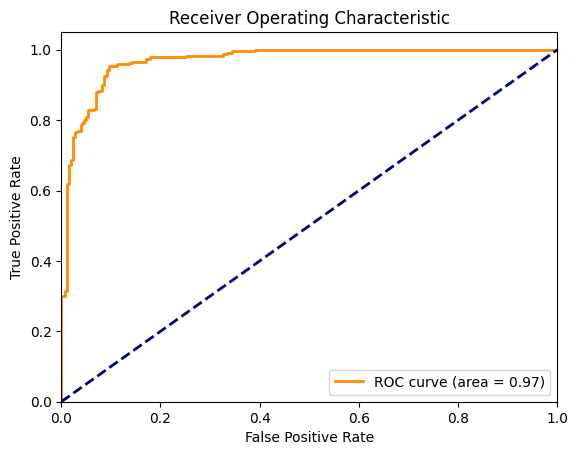

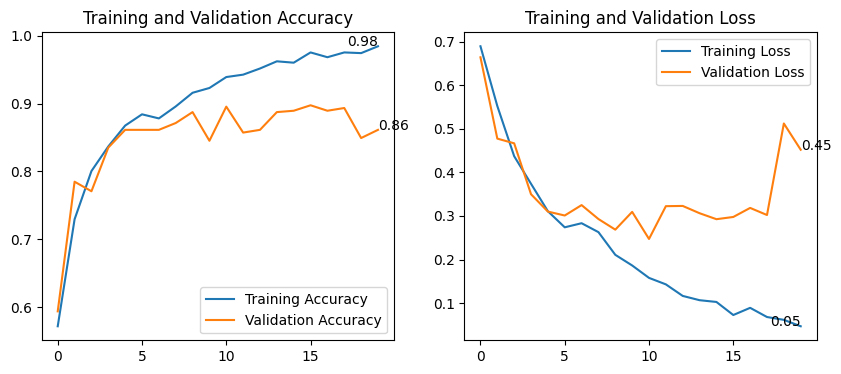

In [56]:
filename = '09_treino_color2'
model_09_treino_color2 = load_model(f'saved_models/{filename}.h5')
history_dict_color2 = load_history(filename)
y_pred_proba_color2 = model_09_treino_color2.predict(val_ds)
y_pred_color2 = (y_pred_proba_color2 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_color2 = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_color2, y_pred_color2, y_pred_proba_color2)
plot_accuracy(history_dict_color2, epochs_color2)

* Ao contrário do primeiro caso, onde o drop auxiliou o modelo, neste caso, acabou sendo prejudicado.
* Entende-se que as mudanças nas cores influenciaram negativamente o modelo.
* A seguir, faz-se o teste ajustando apenas o brilho/contraste da imagem, mantendo o hue igual.

In [57]:
epochs_bc = 20
final_model_bc = create_model()
augmented_train_ds_bc = train_ds.map(lambda x, y: (data_aug_bc(x, training=True), y))
history_bc = final_model_bc.fit(augmented_train_ds_bc, epochs=epochs_bc, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 28s 423ms/step - loss: 0.6286 - accuracy: 0.6477 - val_loss: 0.5713 - val_accuracy: 0.7404
Epoch 2/20
62/62 [==============================] - 28s 449ms/step - loss: 0.4484 - accuracy: 0.8029 - val_loss: 0.4149 - val_accuracy: 0.8249
Epoch 3/20
62/62 [==============================] - 27s 426ms/step - loss: 0.3707 - accuracy: 0.8382 - val_loss: 0.3944 - val_accuracy: 0.8410
Epoch 4/20
62/62 [==============================] - 28s 459ms/step - loss: 0.3075 - accuracy: 0.8664 - val_loss: 0.3305 - val_accuracy: 0.8632
Epoch 5/20
62/62 [==============================] - 28s 459ms/step - loss: 0.2473 - accuracy: 0.8931 - val_loss: 0.3404 - val_accuracy: 0.8511
Epoch 6/20
62/62 [==============================] - 27s 429ms/step - loss: 0.2359 - accuracy: 0.9022 - val_loss: 0.2613 - val_accuracy: 0.8994
Epoch 7/20
62/62 [==============================] - 26s 411ms/step - loss: 0.2082 - accuracy: 0.9148 - val_loss: 0.2614 - val_accuracy: 0.8974

In [58]:
filename = '10_treino_bc'
final_model_bc.save(f'saved_models/{filename}.h5')
save_history(history_bc, filename)

16/16 [==============================] - 2s 136ms/step
Confusion Matrix:
 [[234  24]
 [ 12 227]]
Accuracy: 0.9275653923541247
F1 Score: 0.926530612244898
ROC AUC: 0.9765820116116896


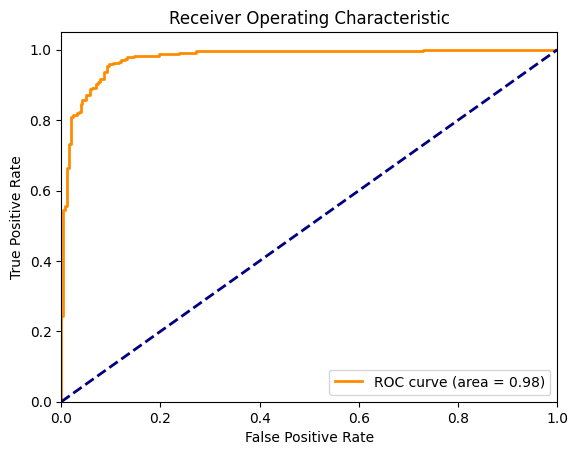

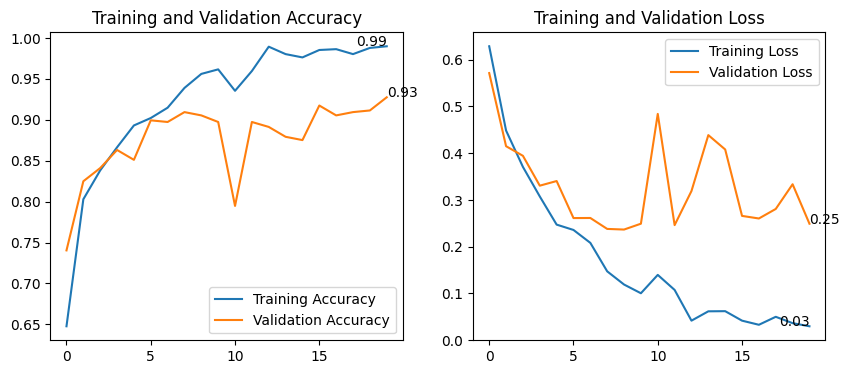

In [59]:
filename = '10_treino_bc'
model_10_treino_bc = load_model(f'saved_models/{filename}.h5')
history_dict_bc = load_history(filename)
y_pred_proba_bc = model_10_treino_bc.predict(val_ds)
y_pred_bc = (y_pred_proba_bc > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_bc = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_bc, y_pred_bc, y_pred_proba_bc)
plot_accuracy(history_dict_bc, epochs_bc)

In [60]:
epochs_bc2 = 20
final_model_bc2 = create_model()
augmented_train_ds_bc2 = train_ds.map(lambda x, y: (data_aug_bc(x, training=True), y))
history_bc2 = final_model_bc2.fit(augmented_train_ds_bc2, epochs=epochs_bc2, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 35s 523ms/step - loss: 0.6620 - accuracy: 0.6144 - val_loss: 0.5664 - val_accuracy: 0.7505
Epoch 2/20
62/62 [==============================] - 32s 522ms/step - loss: 0.4797 - accuracy: 0.7722 - val_loss: 0.4879 - val_accuracy: 0.7827
Epoch 3/20
62/62 [==============================] - 32s 510ms/step - loss: 0.4105 - accuracy: 0.8090 - val_loss: 0.3879 - val_accuracy: 0.8390
Epoch 4/20
62/62 [==============================] - 29s 457ms/step - loss: 0.3421 - accuracy: 0.8498 - val_loss: 0.3892 - val_accuracy: 0.8491
Epoch 5/20
62/62 [==============================] - 28s 457ms/step - loss: 0.3029 - accuracy: 0.8735 - val_loss: 0.3451 - val_accuracy: 0.8491
Epoch 6/20
62/62 [==============================] - 29s 461ms/step - loss: 0.2618 - accuracy: 0.8881 - val_loss: 0.3335 - val_accuracy: 0.8632
Epoch 7/20
62/62 [==============================] - 29s 464ms/step - loss: 0.2094 - accuracy: 0.9153 - val_loss: 0.2921 - val_accuracy: 0.8773

In [61]:
filename = '11_treino_bc2'
final_model_bc2.save(f'saved_models/{filename}.h5')
save_history(history_bc2, filename)

16/16 [==============================] - 2s 124ms/step
Confusion Matrix:
 [[227  31]
 [ 10 229]]
Accuracy: 0.9175050301810865
F1 Score: 0.9178356713426854
ROC AUC: 0.9709464500016218


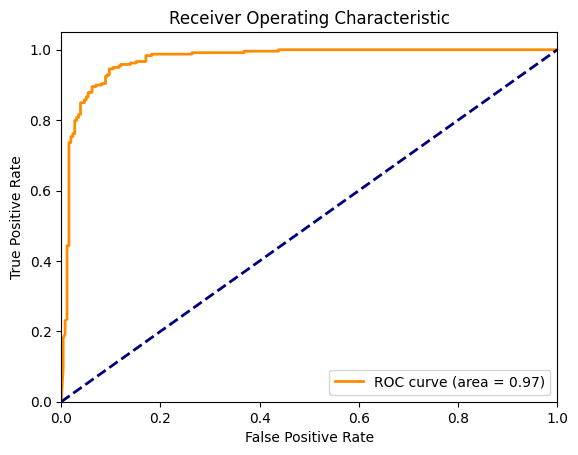

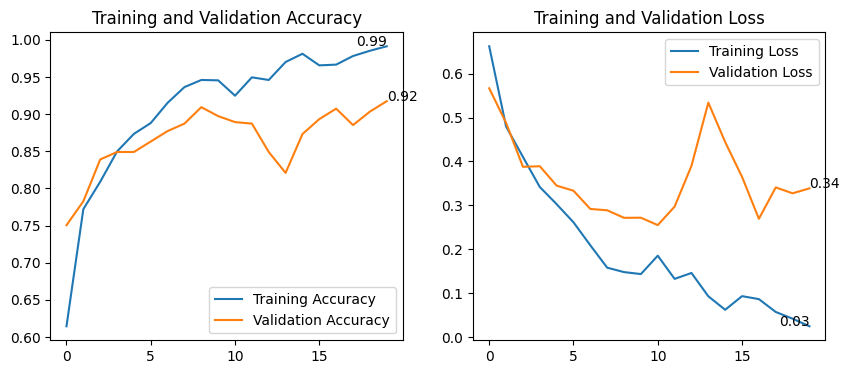

In [62]:
filename = '11_treino_bc2'
model_11_treino_bc2 = load_model(f'saved_models/{filename}.h5')
history_dict_bc2 = load_history(filename)
y_pred_proba_bc2 = model_11_treino_bc2.predict(val_ds)
y_pred_bc2 = (y_pred_proba_bc2 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_bc2 = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_bc2, y_pred_bc2, y_pred_proba_bc2)
plot_accuracy(history_dict_bc2, epochs_bc2)

* Mais uma vez o modelo apresentou overfitting ao continuar reduzindo a perda no treinamento e não acompanhar na validação.
* Tendo sido tratados apenas brilho e contraste, fica, então, a curiosidade para saber se a alteração apenas do hue é capaz de melhorar o treinamento.

In [63]:
epochs_hue = 20
final_model_hue = create_model()
augmented_train_ds_hue = train_ds.map(lambda x, y: (data_aug_hue(x, training=True), y))
history_hue = final_model_hue.fit(augmented_train_ds_hue, epochs=epochs_hue, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 31s 473ms/step - loss: 0.6268 - accuracy: 0.6421 - val_loss: 0.5459 - val_accuracy: 0.7243
Epoch 2/20
62/62 [==============================] - 28s 459ms/step - loss: 0.4020 - accuracy: 0.8256 - val_loss: 0.4028 - val_accuracy: 0.8249
Epoch 3/20
62/62 [==============================] - 29s 461ms/step - loss: 0.3103 - accuracy: 0.8710 - val_loss: 0.3447 - val_accuracy: 0.8632
Epoch 4/20
62/62 [==============================] - 28s 459ms/step - loss: 0.2548 - accuracy: 0.8982 - val_loss: 0.3339 - val_accuracy: 0.8652
Epoch 5/20
62/62 [==============================] - 29s 463ms/step - loss: 0.1975 - accuracy: 0.9229 - val_loss: 0.3188 - val_accuracy: 0.8692
Epoch 6/20
62/62 [==============================] - 28s 448ms/step - loss: 0.1545 - accuracy: 0.9435 - val_loss: 0.2926 - val_accuracy: 0.8833
Epoch 7/20
62/62 [==============================] - 28s 454ms/step - loss: 0.1272 - accuracy: 0.9551 - val_loss: 0.3171 - val_accuracy: 0.8833

In [64]:
filename = '12_treino_hue'
final_model_hue.save(f'saved_models/{filename}.h5')
save_history(history_hue, filename)

16/16 [==============================] - 2s 136ms/step
Confusion Matrix:
 [[237  21]
 [ 14 225]]
Accuracy: 0.9295774647887324
F1 Score: 0.9278350515463917
ROC AUC: 0.981349939995459


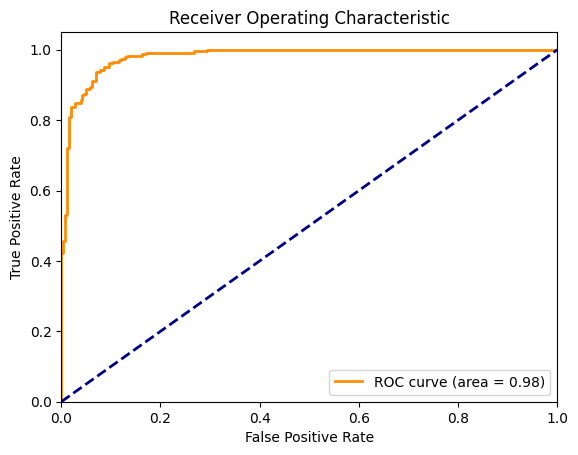

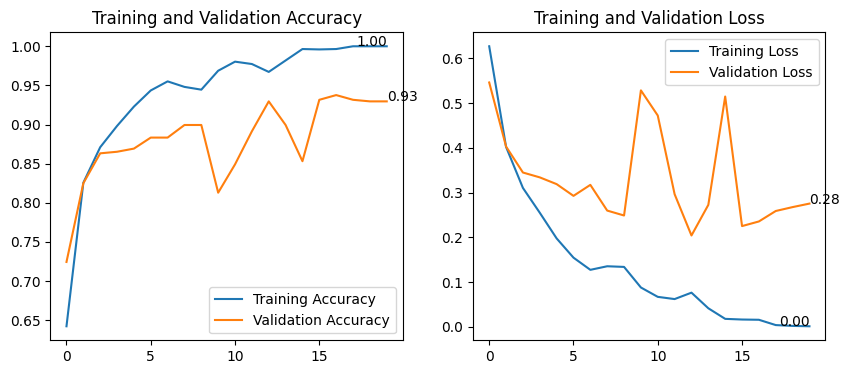

In [65]:
filename = '12_treino_hue'
model_12_treino_hue = load_model(f'saved_models/{filename}.h5')
history_dict_hue = load_history(filename)
y_pred_proba_hue = model_12_treino_hue.predict(val_ds)
y_pred_hue = (y_pred_proba_hue > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_hue = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_hue, y_pred_hue, y_pred_proba_hue)
plot_accuracy(history_dict_hue, epochs_hue)

In [66]:
epochs_hue2 = 20
final_model_hue2 = create_model_drop()
augmented_train_ds_hue2 = train_ds.map(lambda x, y: (data_aug_hue(x, training=True), y))
history_hue2 = final_model_hue2.fit(augmented_train_ds_hue2, epochs=epochs_hue2, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 32s 479ms/step - loss: 0.6933 - accuracy: 0.5731 - val_loss: 0.6382 - val_accuracy: 0.5895
Epoch 2/20
62/62 [==============================] - 27s 433ms/step - loss: 0.5202 - accuracy: 0.7424 - val_loss: 0.4618 - val_accuracy: 0.7726
Epoch 3/20
62/62 [==============================] - 29s 466ms/step - loss: 0.3910 - accuracy: 0.8286 - val_loss: 0.4292 - val_accuracy: 0.8008
Epoch 4/20
62/62 [==============================] - 29s 460ms/step - loss: 0.3153 - accuracy: 0.8664 - val_loss: 0.3502 - val_accuracy: 0.8571
Epoch 5/20
62/62 [==============================] - 29s 471ms/step - loss: 0.2594 - accuracy: 0.8942 - val_loss: 0.3385 - val_accuracy: 0.8753
Epoch 6/20
62/62 [==============================] - 28s 455ms/step - loss: 0.2243 - accuracy: 0.9068 - val_loss: 0.2861 - val_accuracy: 0.8954
Epoch 7/20
62/62 [==============================] - 28s 449ms/step - loss: 0.2192 - accuracy: 0.9133 - val_loss: 0.2661 - val_accuracy: 0.9014

In [67]:
filename = '13_treino_hue2'
final_model_hue2.save(f'saved_models/{filename}.h5')
save_history(history_hue2, filename)

16/16 [==============================] - 2s 114ms/step
Confusion Matrix:
 [[247  11]
 [ 23 216]]
Accuracy: 0.93158953722334
F1 Score: 0.927038626609442
ROC AUC: 0.9812364178910836


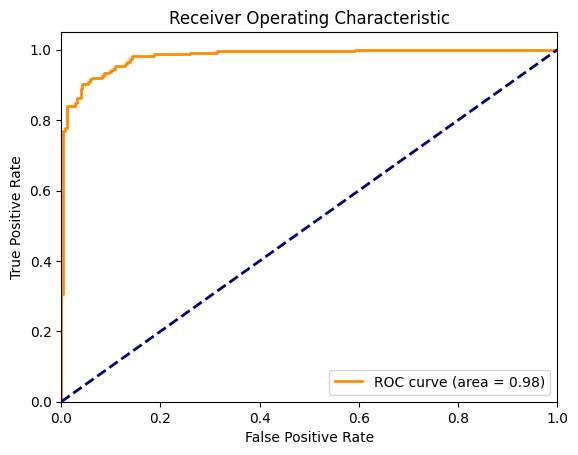

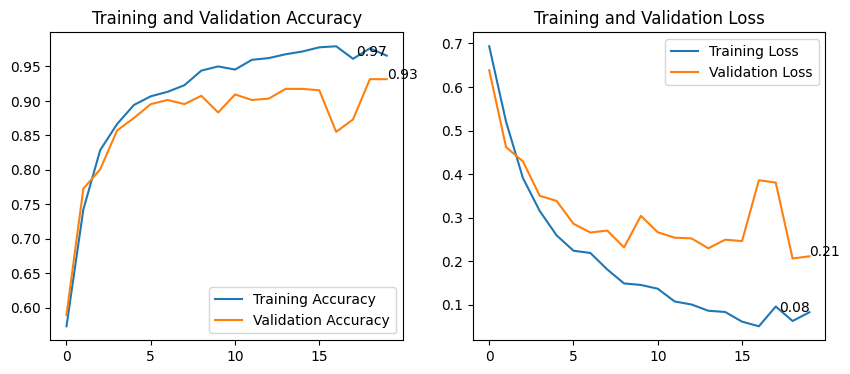

In [68]:
filename = '13_treino_hue2'
model_13_treino_hue2 = load_model(f'saved_models/{filename}.h5')
history_dict_hue2 = load_history(filename)
y_pred_proba_hue2 = model_13_treino_hue2.predict(val_ds)
y_pred_hue2 = (y_pred_proba_hue2 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_hue2 = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_hue2, y_pred_hue2, y_pred_proba_hue2)
plot_accuracy(history_dict_hue2, epochs_hue2)

* Trabalhar o hue isoladamente apresentou um rendimento um pouco melhor do que o ajuste de brilho e contraste.
* Como experimentação, antes de combinar apenas os melhores resultados, tenta-se aplicar todos os ajustes combinados.

In [69]:
epochs_comb = 20
final_model_comb = create_model()
augmented_train_ds_comb = train_ds.map(lambda x, y: (data_aug_comb(x, training=True), y))
history_comb = final_model_comb.fit(augmented_train_ds_comb, epochs=epochs_comb, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 33s 498ms/step - loss: 0.7075 - accuracy: 0.5751 - val_loss: 0.6418 - val_accuracy: 0.6318
Epoch 2/20
62/62 [==============================] - 32s 512ms/step - loss: 0.6171 - accuracy: 0.6613 - val_loss: 0.5778 - val_accuracy: 0.7002
Epoch 3/20
62/62 [==============================] - 30s 487ms/step - loss: 0.5911 - accuracy: 0.6779 - val_loss: 0.6424 - val_accuracy: 0.5976
Epoch 4/20
62/62 [==============================] - 30s 485ms/step - loss: 0.6021 - accuracy: 0.6799 - val_loss: 0.5892 - val_accuracy: 0.6720
Epoch 5/20
62/62 [==============================] - 31s 490ms/step - loss: 0.5756 - accuracy: 0.6951 - val_loss: 0.5911 - val_accuracy: 0.6439
Epoch 6/20
62/62 [==============================] - 31s 490ms/step - loss: 0.5655 - accuracy: 0.7067 - val_loss: 0.6383 - val_accuracy: 0.6177
Epoch 7/20
62/62 [==============================] - 31s 493ms/step - loss: 0.5608 - accuracy: 0.6996 - val_loss: 0.5338 - val_accuracy: 0.7243

In [70]:
filename = '14_treino_comb'
final_model_comb.save(f'saved_models/{filename}.h5')
save_history(history_comb, filename)

16/16 [==============================] - 2s 126ms/step
Confusion Matrix:
 [[250   8]
 [105 134]]
Accuracy: 0.772635814889336
F1 Score: 0.7034120734908138
ROC AUC: 0.9033602542895138


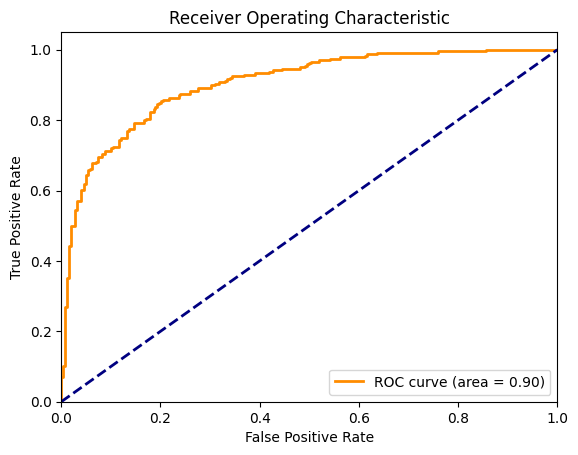

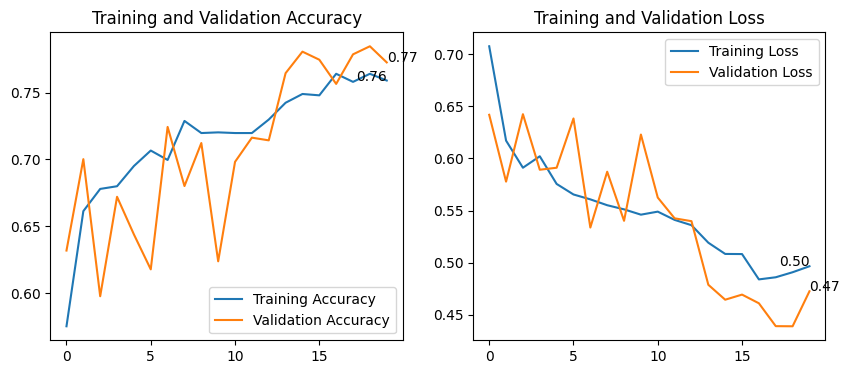

In [71]:
filename = '14_treino_comb'
model_14_treino_comb = load_model(f'saved_models/{filename}.h5')
history_dict_comb = load_history(filename)
y_pred_proba_comb = model_14_treino_comb.predict(val_ds)
y_pred_comb = (y_pred_proba_comb > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_comb = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_comb, y_pred_comb, y_pred_proba_comb)
plot_accuracy(history_dict_comb, epochs_comb)

* Nesta primeira passada do modelo, sem fazer o drop de alguns neuronios, observa-se que a acurácia e perda de treinamento e validação seguiram muito próximas uma das outras, o que pode indicar que o modelo está generalizando bem os dados. 
* Resta a pergunta: será que o treinamento com mais épocas seria capaz de melhorar o modelo, visto que não apresentou sinais de overfitting?

In [72]:
epochs_comb2 = 20
final_model_comb2 = create_model_drop()
augmented_train_ds_comb2 = train_ds.map(lambda x, y: (data_aug_comb(x, training=True), y))
history_comb2 = final_model_comb2.fit(augmented_train_ds_comb2, epochs=epochs_comb2, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 34s 506ms/step - loss: 0.7058 - accuracy: 0.5318 - val_loss: 0.6926 - val_accuracy: 0.5191
Epoch 2/20
62/62 [==============================] - 33s 536ms/step - loss: 0.6836 - accuracy: 0.5650 - val_loss: 0.6476 - val_accuracy: 0.6439
Epoch 3/20
62/62 [==============================] - 30s 488ms/step - loss: 0.6464 - accuracy: 0.6270 - val_loss: 0.6415 - val_accuracy: 0.6298
Epoch 4/20
62/62 [==============================] - 30s 480ms/step - loss: 0.6289 - accuracy: 0.6416 - val_loss: 0.5634 - val_accuracy: 0.7565
Epoch 5/20
62/62 [==============================] - 31s 490ms/step - loss: 0.6074 - accuracy: 0.6709 - val_loss: 0.5928 - val_accuracy: 0.6761
Epoch 6/20
62/62 [==============================] - 30s 487ms/step - loss: 0.6099 - accuracy: 0.6628 - val_loss: 0.5335 - val_accuracy: 0.7706
Epoch 7/20
62/62 [==============================] - 31s 490ms/step - loss: 0.5795 - accuracy: 0.6925 - val_loss: 0.6101 - val_accuracy: 0.6318

In [73]:
filename = '15_treino_comb2'
final_model_comb2.save(f'saved_models/{filename}.h5')
save_history(history_comb2, filename)

16/16 [==============================] - 2s 114ms/step
Confusion Matrix:
 [[225  33]
 [ 66 173]]
Accuracy: 0.8008048289738431
F1 Score: 0.7775280898876404
ROC AUC: 0.8898673413123155


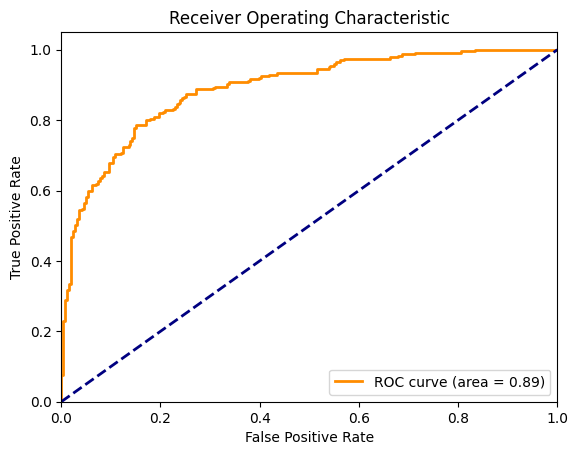

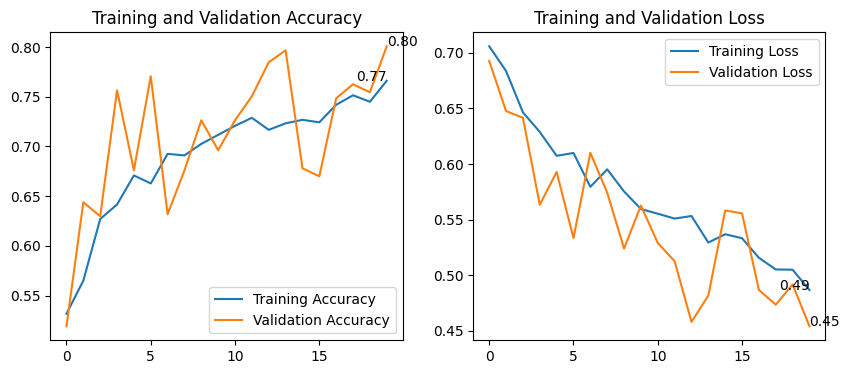

In [74]:
filename = '15_treino_comb2'
model_15_treino_comb2 = load_model(f'saved_models/{filename}.h5')
history_dict_comb2 = load_history(filename)
y_pred_proba_comb2 = model_15_treino_comb2.predict(val_ds)
y_pred_comb2 = (y_pred_proba_comb2 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_comb2 = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_comb2, y_pred_comb2, y_pred_proba_comb2)
plot_accuracy(history_dict_comb2, epochs_comb2)

* Com o treinamento dropando algumas camadas o f1 score caiu muito. 
* No próximo modelo, tenta-se, considerando a queda constante nos erros, calcular a quantidade de épocas que seriam necessárias para que o erro esteja próximo ou abaixo de 0.1.

In [75]:
epochs_comb3 = 100
final_model_comb3 = create_model()
augmented_train_ds_comb3 = train_ds.map(lambda x, y: (data_aug_comb(x, training=True), y))
history_comb3 = final_model_comb3.fit(augmented_train_ds_comb3, epochs=epochs_comb3, batch_size=32, validation_data=val_ds)

Epoch 1/100
62/62 [==============================] - 33s 497ms/step - loss: 0.6880 - accuracy: 0.5539 - val_loss: 0.6501 - val_accuracy: 0.6600
Epoch 2/100
62/62 [==============================] - 31s 493ms/step - loss: 0.6262 - accuracy: 0.6442 - val_loss: 0.6420 - val_accuracy: 0.5915
Epoch 3/100
62/62 [==============================] - 31s 490ms/step - loss: 0.6047 - accuracy: 0.6804 - val_loss: 0.6092 - val_accuracy: 0.6459
Epoch 4/100
62/62 [==============================] - 31s 501ms/step - loss: 0.5796 - accuracy: 0.6956 - val_loss: 0.6126 - val_accuracy: 0.6318
Epoch 5/100
62/62 [==============================] - 31s 497ms/step - loss: 0.5708 - accuracy: 0.7082 - val_loss: 0.5134 - val_accuracy: 0.7465
Epoch 6/100
62/62 [==============================] - 32s 508ms/step - loss: 0.5563 - accuracy: 0.7198 - val_loss: 0.6404 - val_accuracy: 0.6358
Epoch 7/100
62/62 [==============================] - 31s 497ms/step - loss: 0.5562 - accuracy: 0.7233 - val_loss: 0.6607 - val_accuracy:

In [76]:
filename = '16_treino_comb3'
final_model_comb3.save(f'saved_models/{filename}.h5')
save_history(history_comb3, filename)

16/16 [==============================] - 2s 116ms/step
Confusion Matrix:
 [[228  30]
 [ 17 222]]
Accuracy: 0.9054325955734407
F1 Score: 0.9042769857433809
ROC AUC: 0.9763225325159742


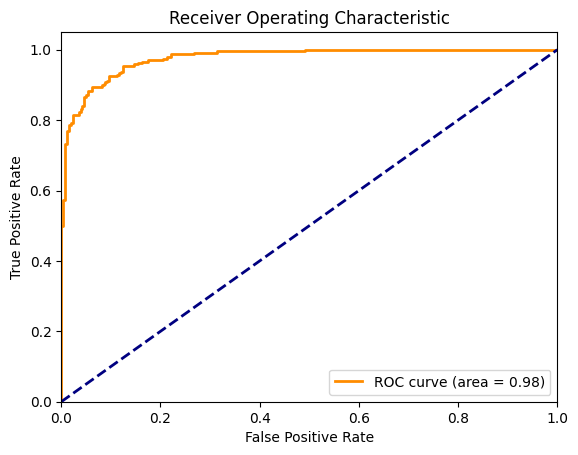

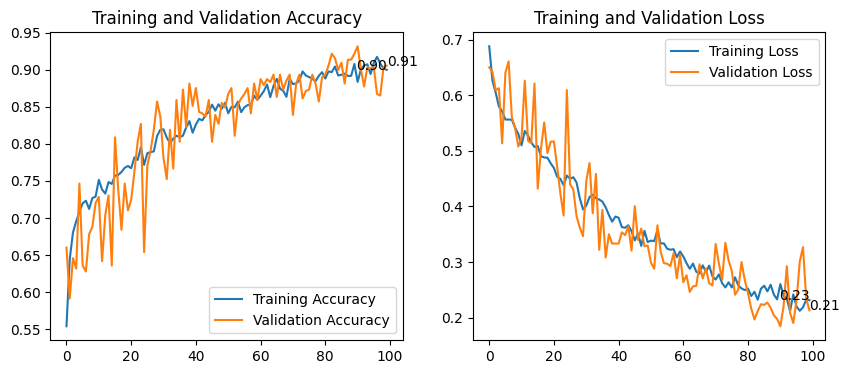

In [77]:
filename = '16_treino_comb3'
model_16_treino_comb3 = load_model(f'saved_models/{filename}.h5')
history_dict_comb3 = load_history(filename)
y_pred_proba_comb3 = model_16_treino_comb3.predict(val_ds)
y_pred_comb3 = (y_pred_proba_comb3 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_comb3 = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_comb3, y_pred_comb3, y_pred_proba_comb3)
plot_accuracy(history_dict_comb3, epochs_comb3)

* Com 100 épocas o modelo conseguiu generalizar bem os dados e a queda da perda foi contínua durante todo o período de treinamento, o que incentivou os autores a dobrar a quantiade de épocas e inserir o drop apenas para ver como o modelo se comporta.
* Considerando que o treinamento alcançou um f1 score de 0.81, espera-se que ultrapasse 90 no próximo treinamento

In [78]:
epochs_comb4 = 200
final_model_comb4 = create_model_drop()
augmented_train_ds_comb4 = train_ds.map(lambda x, y: (data_aug_comb(x, training=True), y))
history_comb4 = final_model_comb4.fit(augmented_train_ds_comb4, epochs=epochs_comb4, batch_size=32, validation_data=val_ds)

Epoch 1/200
62/62 [==============================] - 35s 528ms/step - loss: 0.7017 - accuracy: 0.5610 - val_loss: 0.6717 - val_accuracy: 0.5775
Epoch 2/200
62/62 [==============================] - 32s 509ms/step - loss: 0.6577 - accuracy: 0.6205 - val_loss: 0.6200 - val_accuracy: 0.6318
Epoch 3/200
62/62 [==============================] - 31s 505ms/step - loss: 0.6194 - accuracy: 0.6527 - val_loss: 0.6148 - val_accuracy: 0.6640
Epoch 4/200
62/62 [==============================] - 32s 519ms/step - loss: 0.5970 - accuracy: 0.6784 - val_loss: 0.5332 - val_accuracy: 0.7505
Epoch 5/200
62/62 [==============================] - 32s 516ms/step - loss: 0.5892 - accuracy: 0.6910 - val_loss: 0.6344 - val_accuracy: 0.6217
Epoch 6/200
62/62 [==============================] - 32s 515ms/step - loss: 0.5961 - accuracy: 0.6830 - val_loss: 0.5324 - val_accuracy: 0.7284
Epoch 7/200
62/62 [==============================] - 32s 520ms/step - loss: 0.5791 - accuracy: 0.6870 - val_loss: 0.5901 - val_accuracy:

In [79]:
filename = '17_treino_comb4'
final_model_comb4.save(f'saved_models/{filename}.h5')
save_history(history_comb4, filename)

16/16 [==============================] - 4s 251ms/step
Confusion Matrix:
 [[223  35]
 [  6 233]]
Accuracy: 0.9175050301810865
F1 Score: 0.9191321499013806
ROC AUC: 0.9844717978657844


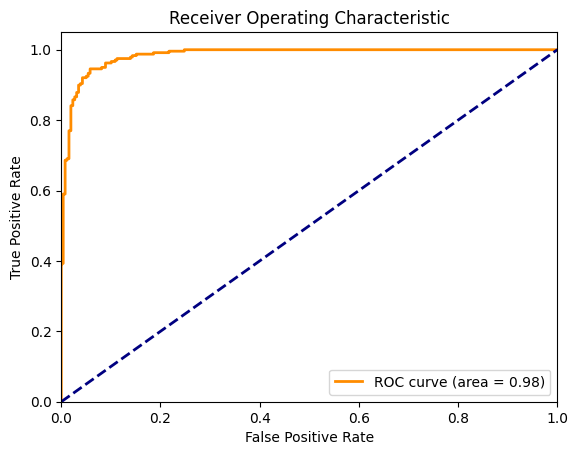

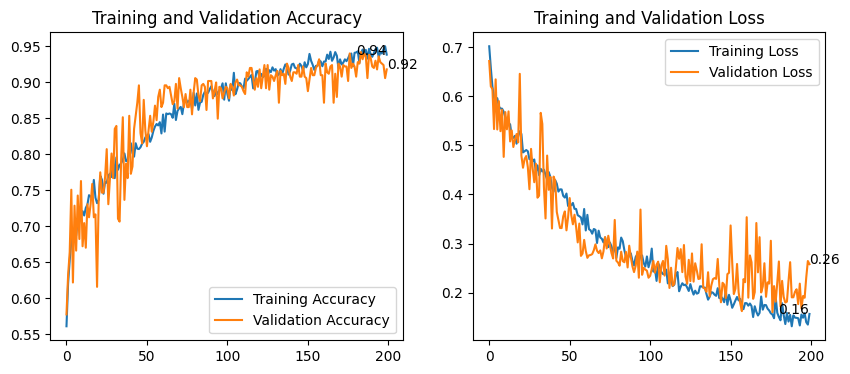

In [80]:
filename = '17_treino_comb4'
model_17_treino_comb4 = load_model(f'saved_models/{filename}.h5')
history_dict_comb4 = load_history(filename)
y_pred_proba_comb4 = model_17_treino_comb4.predict(val_ds)
y_pred_comb4 = (y_pred_proba_comb4 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_comb4 = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_comb4, y_pred_comb4, y_pred_proba_comb4)
plot_accuracy(history_dict_comb4, epochs_comb4)

* Observa-se, neste treinamento que, com todos os dados, a acurácia e perda de treinamento foram constantes, mas por volta da centésima época começou-se a criar uma disparidade entre treinamento e acurácia.
* Tentar-se-á um novo modelo, sem o drop de camadas.

In [81]:
epochs_comb5 = 200
final_model_comb5 = create_model()
augmented_train_ds_comb5 = train_ds.map(lambda x, y: (data_aug_comb(x, training=True), y))
history_comb5 = final_model_comb5.fit(augmented_train_ds_comb5, epochs=epochs_comb5, batch_size=32, validation_data=val_ds)

Epoch 1/200
62/62 [==============================] - 62s 937ms/step - loss: 0.7342 - accuracy: 0.5454 - val_loss: 0.6863 - val_accuracy: 0.5191
Epoch 2/200
62/62 [==============================] - 53s 856ms/step - loss: 0.6555 - accuracy: 0.5983 - val_loss: 0.6458 - val_accuracy: 0.5795
Epoch 3/200
62/62 [==============================] - 59s 940ms/step - loss: 0.6195 - accuracy: 0.6557 - val_loss: 0.6447 - val_accuracy: 0.5915
Epoch 4/200
62/62 [==============================] - 64s 1s/step - loss: 0.6063 - accuracy: 0.6815 - val_loss: 0.6252 - val_accuracy: 0.6056
Epoch 5/200
62/62 [==============================] - 59s 955ms/step - loss: 0.6068 - accuracy: 0.6774 - val_loss: 0.6008 - val_accuracy: 0.6519
Epoch 6/200
62/62 [==============================] - 58s 936ms/step - loss: 0.5885 - accuracy: 0.6885 - val_loss: 0.6481 - val_accuracy: 0.6398
Epoch 7/200
62/62 [==============================] - 58s 936ms/step - loss: 0.6053 - accuracy: 0.6835 - val_loss: 0.6680 - val_accuracy: 0.

In [82]:
filename = '18_treino_comb5'
final_model_comb5.save(f'saved_models/{filename}.h5')
save_history(history_comb5, filename)

16/16 [==============================] - 4s 206ms/step
Confusion Matrix:
 [[234  24]
 [ 19 220]]
Accuracy: 0.9134808853118712
F1 Score: 0.9109730848861285
ROC AUC: 0.9814310272128701


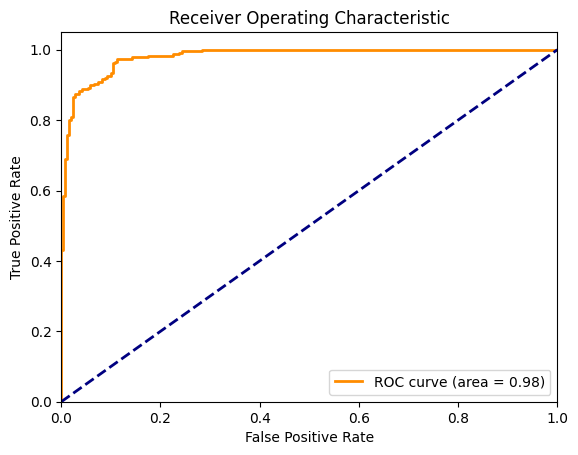

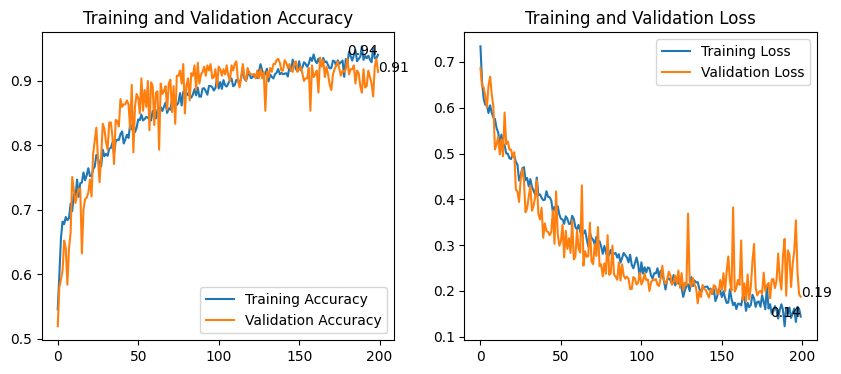

In [83]:
filename = '18_treino_comb5'
model_18_treino_comb5 = load_model(f'saved_models/{filename}.h5')
history_dict_comb5 = load_history(filename)
y_pred_proba_comb5 = model_18_treino_comb5.predict(val_ds)
y_pred_comb5 = (y_pred_proba_comb5 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_comb5 = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_comb5, y_pred_comb5, y_pred_proba_comb5)
plot_accuracy(history_dict_comb5, epochs_comb5)

* Apesar de ter encontrado um f1 score de 0.95, percebe-se pelo gráfico de acurácia e erro que a validação não acompanhou o treinamento após aproximadamente 140 épocas.
* Mais ajustes são necessários para um modelo melhor.

### Treino com zoom, flip e hue com drop

In [85]:
epochs_zoom_flip_hue = 20
final_model_zoom_flip_hue = create_model_drop()
augmented_train_ds_zoom_flip_hue = train_ds.map(lambda x, y: (data_aug_zoom_flip_hue(x, training=True), y))
history_zoom_flip_hue = final_model_zoom_flip_hue.fit(augmented_train_ds_zoom_flip_hue, epochs=epochs_zoom_flip_hue, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 33s 493ms/step - loss: 0.6665 - accuracy: 0.5948 - val_loss: 0.6009 - val_accuracy: 0.7123
Epoch 2/20
62/62 [==============================] - 32s 508ms/step - loss: 0.5889 - accuracy: 0.6946 - val_loss: 0.5400 - val_accuracy: 0.7223
Epoch 3/20
62/62 [==============================] - 32s 516ms/step - loss: 0.5251 - accuracy: 0.7399 - val_loss: 0.5186 - val_accuracy: 0.7344
Epoch 4/20
62/62 [==============================] - 30s 488ms/step - loss: 0.4801 - accuracy: 0.7732 - val_loss: 0.4083 - val_accuracy: 0.8471
Epoch 5/20
62/62 [==============================] - 30s 485ms/step - loss: 0.4324 - accuracy: 0.8034 - val_loss: 0.4738 - val_accuracy: 0.7586
Epoch 6/20
62/62 [==============================] - 32s 512ms/step - loss: 0.4253 - accuracy: 0.8049 - val_loss: 0.3901 - val_accuracy: 0.8370
Epoch 7/20
62/62 [==============================] - 29s 468ms/step - loss: 0.3962 - accuracy: 0.8241 - val_loss: 0.3592 - val_accuracy: 0.8451

In [86]:
filename = '19_treino_zomm_flip_hue'
final_model_zoom_flip_hue.save(f'saved_models/{filename}.h5')
save_history(history_zoom_flip_hue, filename)

16/16 [==============================] - 2s 130ms/step
Confusion Matrix:
 [[231  27]
 [ 22 217]]
Accuracy: 0.9014084507042254
F1 Score: 0.898550724637681
ROC AUC: 0.9670623722876326


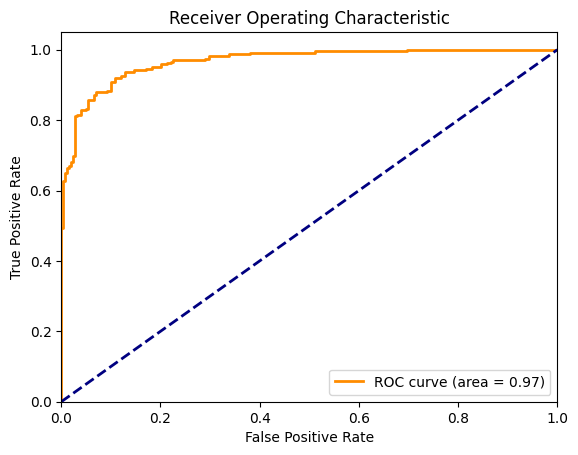

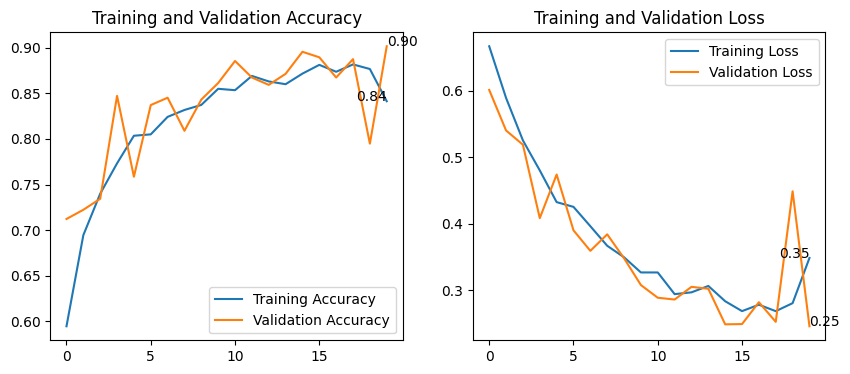

In [87]:
filename = '19_treino_zomm_flip_hue'
model_19_treino_zoom_flip_hue = load_model(f'saved_models/{filename}.h5')
history_dict_zoom_flip_hue = load_history(filename)
y_pred_proba_zoom_flip_hue = model_19_treino_zoom_flip_hue.predict(val_ds)
y_pred_zoom_flip_hue = (y_pred_proba_zoom_flip_hue > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_zoom_flip_hue = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_zoom_flip_hue, y_pred_zoom_flip_hue, y_pred_proba_zoom_flip_hue)
plot_accuracy(history_dict_zoom_flip_hue, epochs_zoom_flip_hue)

* Neste modelo com zoom, flip e hue observou-se que, mesmo que tenha dado um valor alto de F1 score, o modelo apresentou dificuldades de reduzir os erros a partir da 15 época.
* No próximo treinamento, optou-se por remover a cama de drop do modelo.

In [89]:
epochs_zoom_flip_hue_sd = 20
final_model_zoom_flip_hue_sd = create_model()
augmented_train_ds_zoom_flip_hue_sd = train_ds.map(lambda x, y: (data_aug_zoom_flip_hue(x, training=True), y))
history_zoom_flip_hue_sd = final_model_zoom_flip_hue_sd.fit(augmented_train_ds_zoom_flip_hue_sd, epochs=epochs_zoom_flip_hue_sd, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 32s 483ms/step - loss: 0.6939 - accuracy: 0.5454 - val_loss: 0.6793 - val_accuracy: 0.5272
Epoch 2/20
62/62 [==============================] - 31s 495ms/step - loss: 0.6327 - accuracy: 0.6356 - val_loss: 0.5977 - val_accuracy: 0.6881
Epoch 3/20
62/62 [==============================] - 31s 500ms/step - loss: 0.5437 - accuracy: 0.7298 - val_loss: 0.4951 - val_accuracy: 0.7686
Epoch 4/20
62/62 [==============================] - 30s 487ms/step - loss: 0.4802 - accuracy: 0.7767 - val_loss: 0.4580 - val_accuracy: 0.7807
Epoch 5/20
62/62 [==============================] - 31s 497ms/step - loss: 0.4570 - accuracy: 0.7802 - val_loss: 0.4920 - val_accuracy: 0.7404
Epoch 6/20
62/62 [==============================] - 32s 520ms/step - loss: 0.4275 - accuracy: 0.8095 - val_loss: 0.4341 - val_accuracy: 0.7726
Epoch 7/20
62/62 [==============================] - 34s 545ms/step - loss: 0.3777 - accuracy: 0.8322 - val_loss: 0.6812 - val_accuracy: 0.6801

In [90]:
filename = '20_treino_zomm_flip_hue_sd'
final_model_zoom_flip_hue_sd.save(f'saved_models/{filename}.h5')
save_history(history_zoom_flip_hue_sd, filename)

16/16 [==============================] - 2s 123ms/step
Confusion Matrix:
 [[200  58]
 [ 21 218]]
Accuracy: 0.8410462776659959
F1 Score: 0.8466019417475729
ROC AUC: 0.9345301806623204


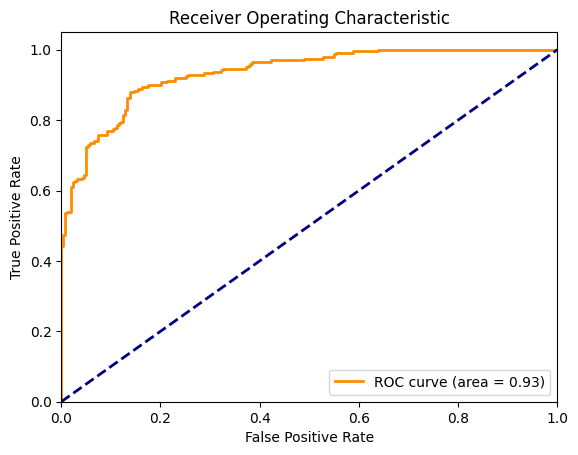

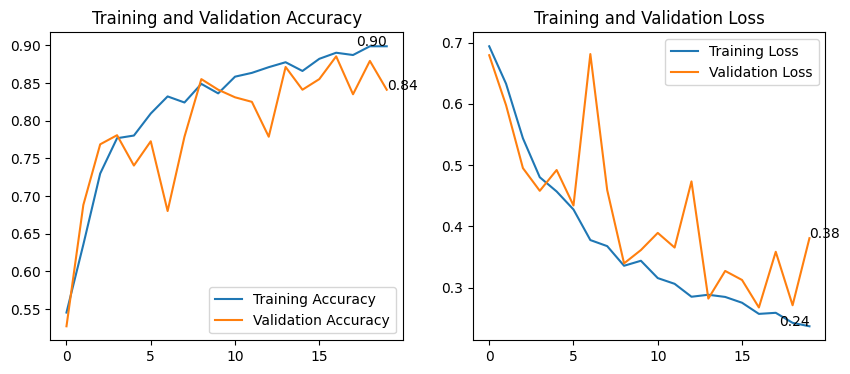

In [91]:
filename = '20_treino_zomm_flip_hue_sd'
model_20_treino_zoom_flip_hue_sd = load_model(f'saved_models/{filename}.h5')
history_dict_zoom_flip_hue_sd = load_history(filename)
y_pred_proba_zoom_flip_hue_sd = model_20_treino_zoom_flip_hue_sd.predict(val_ds)
y_pred_zoom_flip_hue_sd = (y_pred_proba_zoom_flip_hue_sd > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_zoom_flip_hue_sd = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_zoom_flip_hue_sd, y_pred_zoom_flip_hue_sd, y_pred_proba_zoom_flip_hue_sd)
plot_accuracy(history_dict_zoom_flip_hue_sd, epochs_zoom_flip_hue_sd)

* Claramente algun dos métodos de image augmentation está interferindo com o treinamento do modelo.
* Para os próximos testes, procura-se identificar qual dos métodos que está causando esta intereferência.

In [96]:
epochs_zoom_flip = 20
final_model_zoom_flip = create_model()
augmented_train_ds_zoom_flip = train_ds.map(lambda x, y: (data_aug_zoom_flip(x, training=True), y))
history_zoom_flip = final_model_zoom_flip.fit(augmented_train_ds_zoom_flip, epochs=epochs_zoom_flip, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 32s 480ms/step - loss: 0.7040 - accuracy: 0.5529 - val_loss: 0.6286 - val_accuracy: 0.6720
Epoch 2/20
62/62 [==============================] - 30s 484ms/step - loss: 0.6103 - accuracy: 0.6568 - val_loss: 0.6689 - val_accuracy: 0.5714
Epoch 3/20
62/62 [==============================] - 29s 460ms/step - loss: 0.5730 - accuracy: 0.7031 - val_loss: 0.5524 - val_accuracy: 0.7304
Epoch 4/20
62/62 [==============================] - 28s 457ms/step - loss: 0.5278 - accuracy: 0.7369 - val_loss: 0.5374 - val_accuracy: 0.7404
Epoch 5/20
62/62 [==============================] - 29s 461ms/step - loss: 0.4947 - accuracy: 0.7596 - val_loss: 0.4309 - val_accuracy: 0.8270
Epoch 6/20
62/62 [==============================] - 31s 500ms/step - loss: 0.4597 - accuracy: 0.7833 - val_loss: 0.4351 - val_accuracy: 0.8028
Epoch 7/20
62/62 [==============================] - 31s 494ms/step - loss: 0.4204 - accuracy: 0.8039 - val_loss: 0.4265 - val_accuracy: 0.8129

In [97]:
filename = '21_treino_zomm_flip'
final_model_zoom_flip.save(f'saved_models/{filename}.h5')
save_history(history_zoom_flip, filename)

16/16 [==============================] - 2s 136ms/step
Confusion Matrix:
 [[232  26]
 [ 31 208]]
Accuracy: 0.8853118712273642
F1 Score: 0.8794926004228331
ROC AUC: 0.9560345107197302


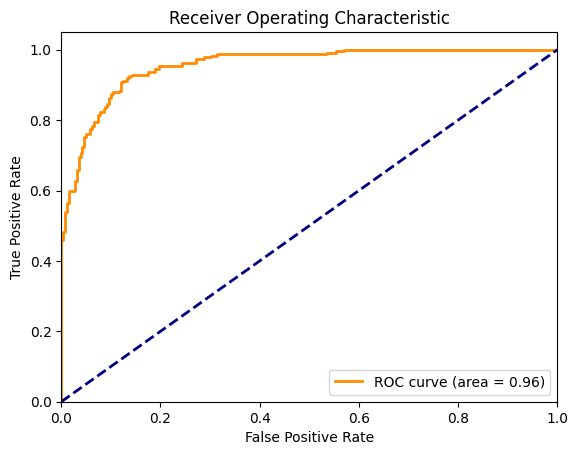

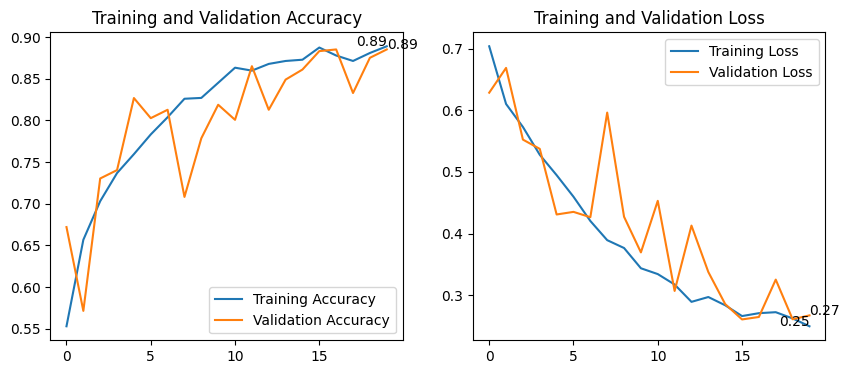

In [98]:
filename = '21_treino_zomm_flip'
model_21_treino_zoom_flip = load_model(f'saved_models/{filename}.h5')
history_dict_zoom_flip = load_history(filename)
y_pred_proba_zoom_flip = model_21_treino_zoom_flip.predict(val_ds)
y_pred_zoom_flip = (y_pred_proba_zoom_flip > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_zoom_flip = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_zoom_flip, y_pred_zoom_flip, y_pred_proba_zoom_flip)
plot_accuracy(history_dict_zoom_flip, epochs_zoom_flip)

In [99]:
epochs_zoom_hue = 20
final_model_zoom_hue = create_model()
augmented_train_ds_zoom_hue = train_ds.map(lambda x, y: (data_aug_zoom_hue(x, training=True), y))
history_zoom_hue = final_model_zoom_hue.fit(augmented_train_ds_zoom_hue, epochs=epochs_zoom_hue, batch_size=32, validation_data=val_ds)

Epoch 1/20
62/62 [==============================] - 32s 480ms/step - loss: 0.6261 - accuracy: 0.6331 - val_loss: 0.5348 - val_accuracy: 0.7505
Epoch 2/20
62/62 [==============================] - 28s 452ms/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.5601 - val_accuracy: 0.7103
Epoch 3/20
62/62 [==============================] - 28s 448ms/step - loss: 0.3830 - accuracy: 0.8281 - val_loss: 0.5668 - val_accuracy: 0.7203
Epoch 4/20
62/62 [==============================] - 28s 449ms/step - loss: 0.3035 - accuracy: 0.8750 - val_loss: 0.7520 - val_accuracy: 0.6821
Epoch 5/20
62/62 [==============================] - 29s 472ms/step - loss: 0.2558 - accuracy: 0.8967 - val_loss: 0.4886 - val_accuracy: 0.7887
Epoch 6/20
62/62 [==============================] - 29s 471ms/step - loss: 0.2595 - accuracy: 0.8952 - val_loss: 0.3939 - val_accuracy: 0.8310
Epoch 7/20
62/62 [==============================] - 29s 466ms/step - loss: 0.2207 - accuracy: 0.9103 - val_loss: 0.4676 - val_accuracy: 0.8008

In [100]:
filename = '22_treino_zoom_hue'
final_model_zoom_hue.save(f'saved_models/{filename}.h5')
save_history(history_zoom_hue, filename)

16/16 [==============================] - 2s 133ms/step
Confusion Matrix:
 [[241  17]
 [  8 231]]
Accuracy: 0.9496981891348089
F1 Score: 0.9486652977412731
ROC AUC: 0.9884369627971847


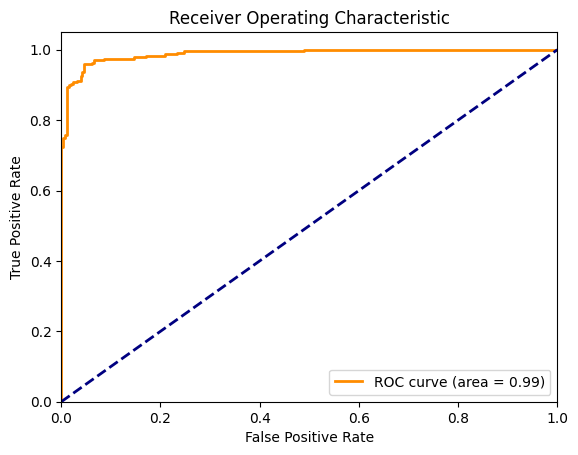

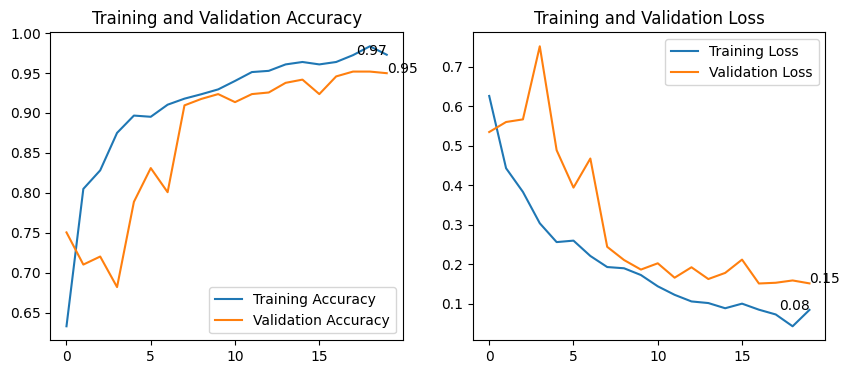

In [101]:
filename = '22_treino_zoom_hue'
model_22_treino_zoom_hue = load_model(f'saved_models/{filename}.h5')
history_dict_zoom_hue = load_history(filename)
y_pred_proba_zoom_hue = model_22_treino_zoom_hue.predict(val_ds)
y_pred_zoom_hue = (y_pred_proba_zoom_hue > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_zoom_hue = np.concatenate([y for x, y in val_ds], axis=0)

# Avalie o modelo com as métricas'
evaluate_model(y_true_zoom_hue, y_pred_zoom_hue, y_pred_proba_zoom_hue)
plot_accuracy(history_dict_zoom_hue, epochs_zoom_hue)

* O resultado com zoom e hue chegou muito próximo do resultado com zoom apenas.

In [30]:
batch_size = 32
img_size = 200

train_ds_2 = create_dataset_image_size(X_train, y_train, img_size).batch(batch_size)
val_ds_2 = create_dataset_image_size(X_test, y_test, img_size).batch(batch_size)

In [31]:
epochs_zoom_30 = 30
final_model_zoom_30 = create_model_image_size(img_size)
augmented_train_ds_zoom_30 = train_ds_2.map(lambda x, y: (data_aug_zoom(x, training=True), y))
history_zoom_30 = final_model_zoom_30.fit(augmented_train_ds_zoom_30, epochs=epochs_zoom_30, batch_size=32, validation_data=val_ds_2)

Epoch 1/30
62/62 [==============================] - 106s 2s/step - loss: 0.6418 - accuracy: 0.6154 - val_loss: 0.5250 - val_accuracy: 0.7465
Epoch 2/30
62/62 [==============================] - 115s 2s/step - loss: 0.4434 - accuracy: 0.7959 - val_loss: 0.6621 - val_accuracy: 0.7304
Epoch 3/30
62/62 [==============================] - 120s 2s/step - loss: 0.3635 - accuracy: 0.8528 - val_loss: 0.4072 - val_accuracy: 0.8350
Epoch 4/30
62/62 [==============================] - 120s 2s/step - loss: 0.3302 - accuracy: 0.8513 - val_loss: 0.3575 - val_accuracy: 0.8571
Epoch 5/30
62/62 [==============================] - 121s 2s/step - loss: 0.2917 - accuracy: 0.8755 - val_loss: 0.3231 - val_accuracy: 0.8652
Epoch 6/30
62/62 [==============================] - 127s 2s/step - loss: 0.2443 - accuracy: 0.8967 - val_loss: 0.3770 - val_accuracy: 0.8511
Epoch 7/30
62/62 [==============================] - 122s 2s/step - loss: 0.2053 - accuracy: 0.9189 - val_loss: 0.2212 - val_accuracy: 0.9115
Epoch 8/30
62

In [32]:
filename = '23_treino_zoom_30'
final_model_zoom_30.save(f'saved_models/{filename}.h5')
save_history(history_zoom_30, filename)

16/16 [==============================] - 6s 349ms/step
Confusion Matrix:
 [[248  10]
 [  8 231]]
Accuracy: 0.9637826961770624
F1 Score: 0.9625
ROC AUC: 0.9923778015633615


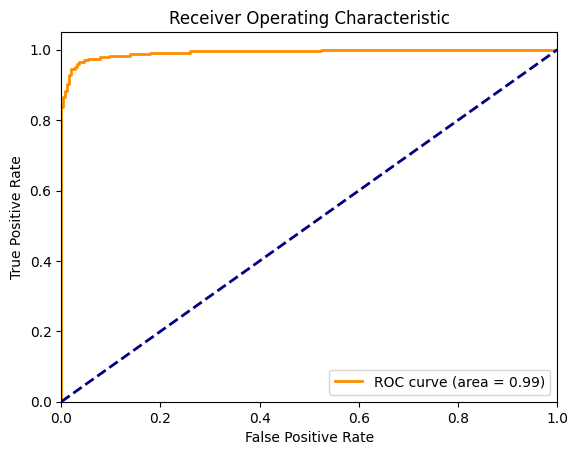

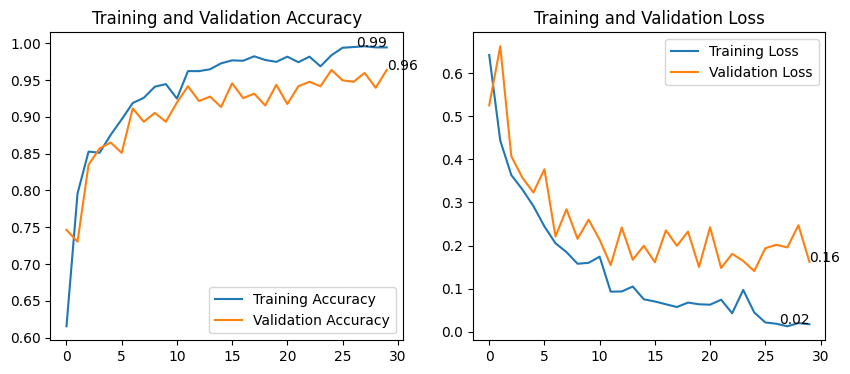

In [33]:
filename = '23_treino_zoom_30'
model_23_treino_zoom_30 = load_model(f'saved_models/{filename}.h5')
history_dict_zoom_30 = load_history(filename)
y_pred_proba_zoom_30 = model_23_treino_zoom_30.predict(val_ds_2)
y_pred_zoom_30 = (y_pred_proba_zoom_30 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_zoom_30 = np.concatenate([y for x, y in val_ds_2], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_zoom_30, y_pred_zoom_30, y_pred_proba_zoom_30)
plot_accuracy(history_dict_zoom_30, epochs_zoom_30)

* O treino abaixo aplica regularização L2 (weight decay) para tentar reduzir a tendência ao overfitting

In [39]:
batch_size = 32
img_size = 200

train_ds_2 = create_dataset_image_size(X_train, y_train, img_size).batch(batch_size)
val_ds_2 = create_dataset_image_size(X_test, y_test, img_size).batch(batch_size)

In [40]:
epochs_zoom_l2 = 30
final_model_zoom_l2 = create_model_l2(img_size)
augmented_train_ds_zoom_l2 = train_ds_2.map(lambda x, y: (data_aug_zoom(x, training=True), y))
history_zoom_l2 = final_model_zoom_l2.fit(augmented_train_ds_zoom_l2, epochs=epochs_zoom_l2, batch_size=32, validation_data=val_ds_2)

Epoch 1/30
62/62 [==============================] - 66s 1s/step - loss: 1.3847 - accuracy: 0.5706 - val_loss: 0.8826 - val_accuracy: 0.7062
Epoch 2/30
62/62 [==============================] - 62s 1s/step - loss: 0.7478 - accuracy: 0.6976 - val_loss: 0.7310 - val_accuracy: 0.6801
Epoch 3/30
62/62 [==============================] - 64s 1s/step - loss: 0.6307 - accuracy: 0.7802 - val_loss: 0.6940 - val_accuracy: 0.7123
Epoch 4/30
62/62 [==============================] - 62s 992ms/step - loss: 0.5635 - accuracy: 0.8039 - val_loss: 0.5746 - val_accuracy: 0.7988
Epoch 5/30
62/62 [==============================] - 62s 990ms/step - loss: 0.5297 - accuracy: 0.8130 - val_loss: 0.4861 - val_accuracy: 0.8471
Epoch 6/30
62/62 [==============================] - 63s 1s/step - loss: 0.5095 - accuracy: 0.8065 - val_loss: 0.4731 - val_accuracy: 0.8410
Epoch 7/30
62/62 [==============================] - 62s 997ms/step - loss: 0.4834 - accuracy: 0.8216 - val_loss: 0.6128 - val_accuracy: 0.7344
Epoch 8/30


In [41]:
filename = '24_treino_zoom_l2'
final_model_zoom_l2.save(f'saved_models/{filename}.h5')
save_history(history_zoom_l2, filename)

16/16 [==============================] - 4s 266ms/step
Confusion Matrix:
 [[199  59]
 [  4 235]]
Accuracy: 0.8732394366197183
F1 Score: 0.8818011257035647
ROC AUC: 0.9775064058901755


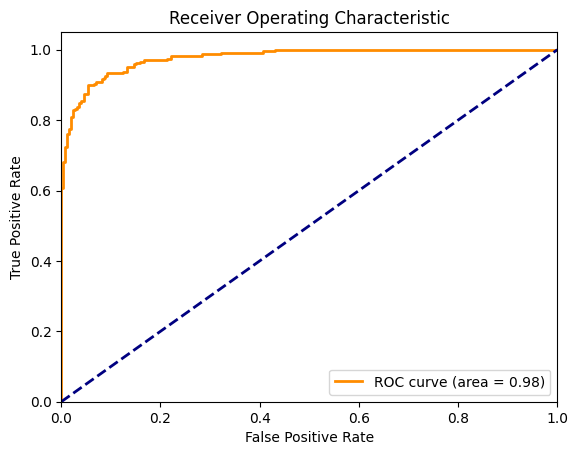

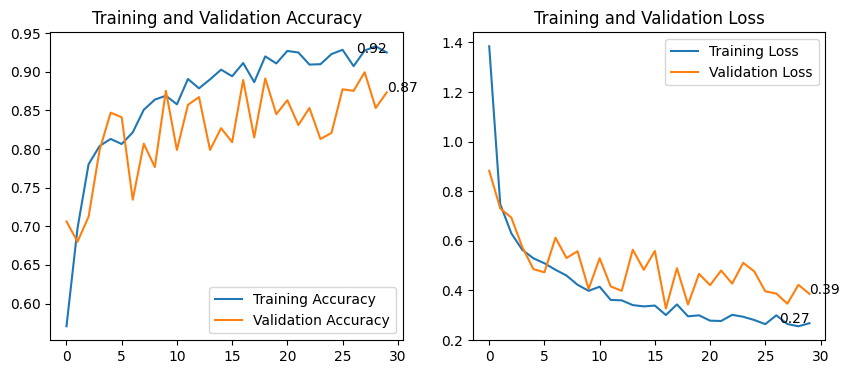

In [42]:
filename = '24_treino_zoom_l2'
model_23_treino_zoom_l2 = load_model(f'saved_models/{filename}.h5')
history_dict_zoom_l2 = load_history(filename)
y_pred_proba_zoom_l2 = model_23_treino_zoom_l2.predict(val_ds_2)
y_pred_zoom_l2 = (y_pred_proba_zoom_l2 > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_zoom_l2 = np.concatenate([y for x, y in val_ds_2], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_zoom_l2, y_pred_zoom_l2, y_pred_proba_zoom_l2)
plot_accuracy(history_dict_zoom_l2, epochs_zoom_l2)

* Esse modelo não ficou muito bom. A técnica de regularização L2 não ajudou a manter o loss da validação próxima da loss do treino, o mesmo aconteceu para o treinamento.

### O bloco de código abaixo considera um modelo que funciona como playground, com valores variados de camadas ocultas etc.

In [73]:
def create_model_playground(image_size):
    model = tf.keras.Sequential([
        # camada de entrada
        tf.keras.layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)),
        # camadas ocultas
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        # camada de saída
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    return model

In [74]:
batch_size = 32
img_size = 200

train_ds_3 = create_dataset_image_size(X_train, y_train, img_size).batch(batch_size)
val_ds_3 = create_dataset_image_size(X_test, y_test, img_size).batch(batch_size)

In [75]:
epochs_zoom_plg = 30
final_model_zoom_plg = create_model_playground(img_size)
augmented_train_ds_zoom_plg = train_ds_3.map(lambda x, y: (data_aug_zoom(x, training=True), y))
history_zoom_plg = final_model_zoom_plg.fit(augmented_train_ds_zoom_plg, epochs=epochs_zoom_plg, batch_size=32, validation_data=val_ds_3)

Epoch 1/30
62/62 [==============================] - 35s 540ms/step - loss: 0.6818 - accuracy: 0.5373 - val_loss: 0.6820 - val_accuracy: 0.5191
Epoch 2/30
62/62 [==============================] - 32s 518ms/step - loss: 0.5950 - accuracy: 0.6815 - val_loss: 0.6006 - val_accuracy: 0.6761
Epoch 3/30
62/62 [==============================] - 32s 512ms/step - loss: 0.5202 - accuracy: 0.7500 - val_loss: 0.5034 - val_accuracy: 0.7666
Epoch 4/30
62/62 [==============================] - 32s 520ms/step - loss: 0.4553 - accuracy: 0.7903 - val_loss: 0.5347 - val_accuracy: 0.7565
Epoch 5/30
62/62 [==============================] - 34s 552ms/step - loss: 0.4084 - accuracy: 0.8251 - val_loss: 0.5843 - val_accuracy: 0.7264
Epoch 6/30
62/62 [==============================] - 32s 518ms/step - loss: 0.3626 - accuracy: 0.8463 - val_loss: 0.5498 - val_accuracy: 0.7586
Epoch 7/30
62/62 [==============================] - 32s 514ms/step - loss: 0.3325 - accuracy: 0.8619 - val_loss: 0.3487 - val_accuracy: 0.8753

In [76]:
filename = '25_treino_zoom_plg'
final_model_zoom_plg.save(f'saved_models/{filename}.h5')
save_history(history_zoom_plg, filename)

16/16 [==============================] - 2s 105ms/step
Confusion Matrix:
 [[244  14]
 [  7 232]]
Accuracy: 0.9577464788732394
F1 Score: 0.956701030927835
ROC AUC: 0.9869449579968214


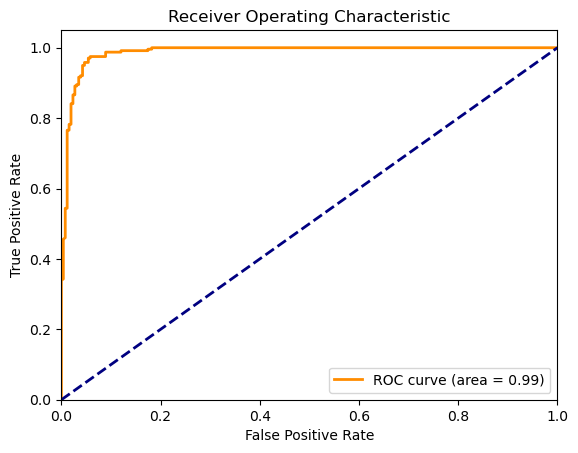

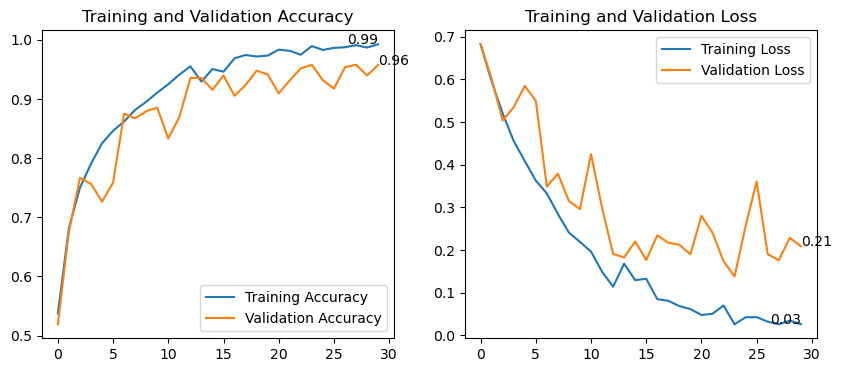

In [77]:
filename = '25_treino_zoom_plg'
model_23_treino_zoom_plg = load_model(f'saved_models/{filename}.h5')
history_dict_zoom_plg = load_history(filename)
y_pred_proba_zoom_plg = model_23_treino_zoom_plg.predict(val_ds_3)
y_pred_zoom_plg = (y_pred_proba_zoom_plg > 0.5).astype("int32")

# Agora, precisamos obter os rótulos verdadeiros (y_true) do conjunto de teste (val_ds)
y_true_zoom_plg = np.concatenate([y for x, y in val_ds_3], axis=0)

# Avalie o modelo com as métricas
evaluate_model(y_true_zoom_plg, y_pred_zoom_plg, y_pred_proba_zoom_plg)
plot_accuracy(history_dict_zoom_plg, epochs_zoom_plg)